# STEP 1: Data Preparation

In [1]:
import pandas as pd
import numpy as np

artists_df = pd.read_csv("/Users/hoon/Desktop/4060J_DataScience_Project/artists.csv")

'''
# Load the preprocessed data 
1) parse & organize -> 2) feature extraction (pretrained ResNet50) -> 3) PCA to reduce dimentionality into 100
'''
image_metadata_reduced_df = pd.read_pickle('/Users/hoon/Desktop/image_metadata_reduced.pkl')


# Normalize artist names in both DataFrames (Albrecht Dürer)
import unicodedata

def normalize_name(name):
    return unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8').strip()

image_metadata_reduced_df['artist_name'] = image_metadata_reduced_df['artist_name'].apply(normalize_name)
artists_df['name'] = artists_df['name'].apply(normalize_name)

# Merge the genre/style information into the image metadata DataFrame
image_metadata_reduced_df = image_metadata_reduced_df.merge(
    artists_df[['name', 'genre']],  # Use the genre or style column from artists.csv
    left_on='artist_name',
    right_on='name',
    how='left'
)

# Drop the duplicate 'name' column
image_metadata_reduced_df.drop(columns=['name'], inplace=True)

# Ensure the 'genre' column exists and has no NaN values
if 'genre' in image_metadata_reduced_df.columns:
    image_metadata_reduced_df['genre'] = image_metadata_reduced_df['genre'].fillna("")
else:
    raise KeyError("The 'genre' column is missing from the DataFrame.")

# Create the 'genre_list' column
image_metadata_reduced_df['genre_list'] = image_metadata_reduced_df['genre'].apply(lambda x: x.split(","))

from sklearn.preprocessing import MultiLabelBinarizer

# One-hot encode the genres
mlb = MultiLabelBinarizer()
one_hot_genres = mlb.fit_transform(image_metadata_reduced_df['genre_list'])

# Add the one-hot encoded genres as columns
genre_columns = mlb.classes_
for idx, genre in enumerate(genre_columns):
    image_metadata_reduced_df[genre] = one_hot_genres[:, idx]

In [3]:
image_metadata_reduced_df.to_pickle("/Users/hoon/Desktop/image_metadata_reduced_genre_encoded.pkl")
image_metadata_reduced_df

,file_name,artist_name,features,artist_label,genre,genre_list,Abstract Expressionism,Abstractionism,Art Nouveau,Baroque,...,Pop Art,Post-Impressionism,Primitivism,Proto Renaissance,Realism,Romanticism,Social Realism,Suprematism,Surrealism,Symbolism
0,Gustav_Klimt_113.jpg,Gustav Klimt,"[-104.051254, -30.065239, 40.834503, -27.93637...",19,"Symbolism,Art Nouveau","[Symbolism, Art Nouveau]",0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,Vincent_van_Gogh_388.jpg,Vincent van Gogh,"[-42.690506, 50.457077, -31.054712, 49.034294,...",48,Post-Impressionism,[Post-Impressionism],0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Amedeo_Modigliani_24.jpg,Amedeo Modigliani,"[85.80638, 74.72588, 21.94299, -97.160614, 6.6...",2,Expressionism,[Expressionism],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Edgar_Degas_455.jpg,Edgar Degas,"[110.57151, -27.310974, -106.109825, -26.60741...",10,Impressionism,[Impressionism],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Edgar_Degas_333.jpg,Edgar Degas,"[128.26991, -22.02461, -65.37852, -10.970957, ...",10,Impressionism,[Impressionism],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8350,Mikhail_Vrubel_116.jpg,Mikhail Vrubel,"[-112.82036, -11.718504, -2.0028427, -15.04778...",32,Symbolism,[Symbolism],0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8351,Joan_Miro_51.jpg,Joan Miro,"[-69.65716, 75.916565, -17.81109, -51.636993, ...",27,Surrealism,[Surrealism],0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8352,Frida_Kahlo_10.jpg,Frida Kahlo,"[53.062565, 15.8918295, -43.91319, -41.854576,...",16,"Primitivism,Surrealism","[Primitivism, Surrealism]",0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
8353,Vincent_van_Gogh_391.jpg,Vincent van Gogh,"[-88.60199, -56.594482, -37.02463, 22.391777, ...",48,Post-Impressionism,[Post-Impressionism],0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


# Step 2: Split Train & Test Data

In [5]:
from sklearn.model_selection import train_test_split

# Extract features and genres (as one-hot encoded labels)
X = np.stack(image_metadata_reduced_df['features'].values)  # Feature matrix
y_genre = image_metadata_reduced_df[genre_columns].values  # One-hot encoded genres

# Add indices to track the split
indices = np.arange(len(X))  # Create indices for the full dataset

# Split the data into training and testing sets, including the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y_genre, indices, test_size=0.2, random_state=42
)

# STEP 3: Model Implementation & Results with Visualizations

In [8]:
import numpy as np
import matplotlib.pyplot as plt

## 3-1: MODEL 1: Simple Neural Network Test

In [11]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.weights = {
            "W1": np.random.randn(input_size, hidden_sizes[0]) * 0.01,
            "W2": np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.01,
            "W3": np.random.randn(hidden_sizes[1], output_size) * 0.01,
        }
        self.biases = {
            "b1": np.zeros((1, hidden_sizes[0])),
            "b2": np.zeros((1, hidden_sizes[1])),
            "b3": np.zeros((1, output_size)),
        }
        self.loss_history = []
        self.accuracy_history = []

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0
    '''
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    '''

    def sigmoid(self, Z):
        Z = np.clip(Z, -500, 500)  # Prevent overflow
        return 1 / (1 + np.exp(-Z))

    def binary_cross_entropy_loss(self, y_pred, y_true):
        n_samples = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)) / n_samples

    def accuracy(self, y_pred, y_true):
        predicted_classes = np.argmax(y_pred, axis=1)
        true_classes = np.argmax(y_true, axis=1)
        return np.mean(predicted_classes == true_classes)

    def forward(self, X):
        self.Z1 = np.dot(X, self.weights["W1"]) + self.biases["b1"]
        self.A1 = self.relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.weights["W2"]) + self.biases["b2"]
        self.A2 = self.relu(self.Z2)

        self.Z3 = np.dot(self.A2, self.weights["W3"]) + self.biases["b3"]
        self.A3 = self.sigmoid(self.Z3)

        return self.A3

    def backward(self, X, y_true, y_pred):
        n_samples = y_true.shape[0]
        dZ3 = y_pred - y_true
        dW3 = np.dot(self.A2.T, dZ3) / n_samples
        db3 = np.sum(dZ3, axis=0, keepdims=True) / n_samples

        dA2 = np.dot(dZ3, self.weights["W3"].T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / n_samples
        db2 = np.sum(dZ2, axis=0, keepdims=True) / n_samples

        dA1 = np.dot(dZ2, self.weights["W2"].T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / n_samples
        db1 = np.sum(dZ1, axis=0, keepdims=True) / n_samples

        self.weights["W1"] -= self.learning_rate * dW1
        self.biases["b1"] -= self.learning_rate * db1
        self.weights["W2"] -= self.learning_rate * dW2
        self.biases["b2"] -= self.learning_rate * db2
        self.weights["W3"] -= self.learning_rate * dW3
        self.biases["b3"] -= self.learning_rate * db3

    def train(self, X, y, epochs=20, batch_size=32):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch, y_pred)

            y_pred_full = self.forward(X)
            loss = self.binary_cross_entropy_loss(y_pred_full, y)
            acc = self.accuracy(y_pred_full, y)
            self.loss_history.append(loss)
            self.accuracy_history.append(acc)
            #print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    def predict(self, X):
        y_pred = self.forward(X)
        max_probs = np.max(y_pred, axis=1)
        max_labels = np.argmax(y_pred, axis=1)
        return max_probs, max_labels

###  3-1-1: Model Training Progress (small size of hidden layers vs big size)

In [13]:
input_size = X_train.shape[1]
hidden_sizes = [512, 256]
output_size = y_train.shape[1]
learning_rate = 0.01

# Train the model
simple_nn1 = SimpleNeuralNetwork(input_size, hidden_sizes, output_size, learning_rate)
simple_nn1.train(X_train, y_train, epochs=30, batch_size=32)

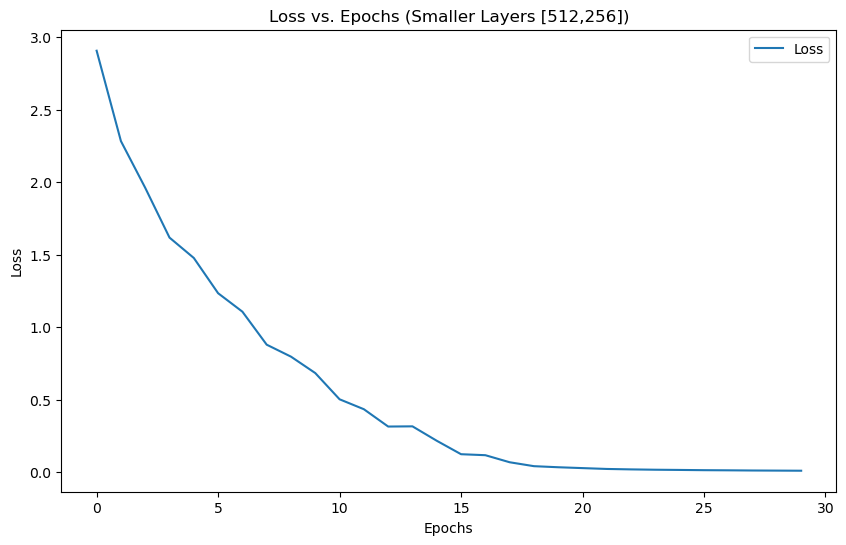

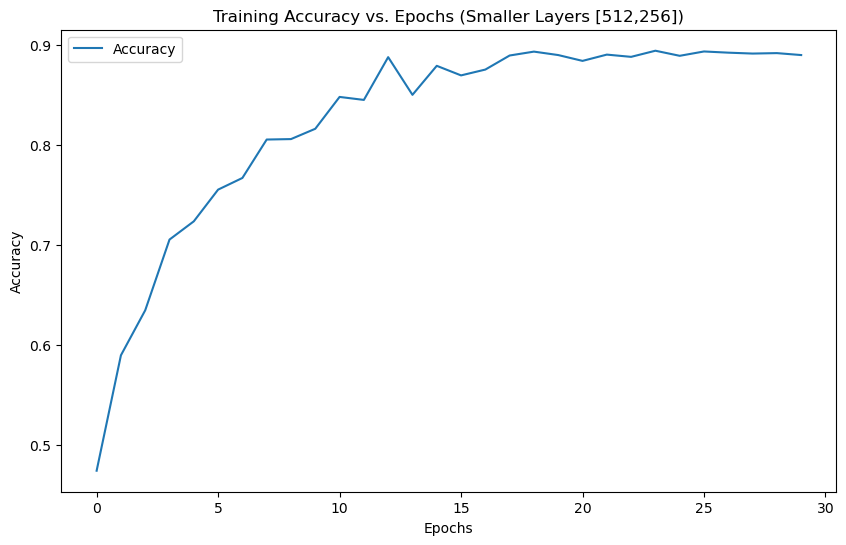

In [21]:
# Plot Loss vs. Epochs
fig = plt.figure(figsize=(10, 6))
plt.plot(simple_nn1.loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Smaller Layers [512,256])')
plt.legend()
plt.show()
fig.savefig('/Users/hoon/Desktop/snn_loss_vs_epoch.jpg')

# Plot Accuracy vs. Epochs
fig = plt.figure(figsize=(10, 6))
plt.plot(simple_nn1.accuracy_history, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs (Smaller Layers [512,256])')
plt.legend()
plt.show()
fig.savefig('/Users/hoon/Desktop/snn_Taccuracy_vs_epoch.jpg')

In [23]:
hidden_sizes = [4096, 2048]
learning_rate = 0.01

# Train the model
simple_nn2 = SimpleNeuralNetwork(input_size, hidden_sizes, output_size, learning_rate)
simple_nn2.train(X_train, y_train, epochs=30, batch_size=32)

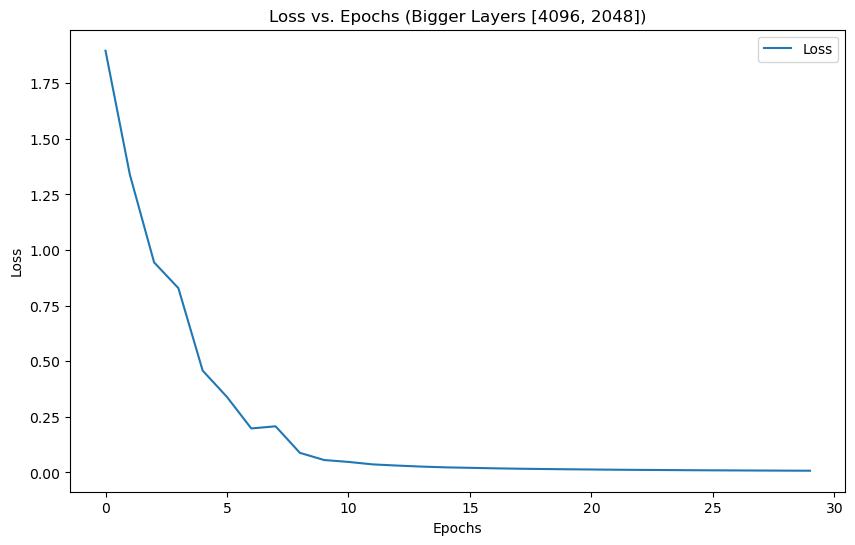

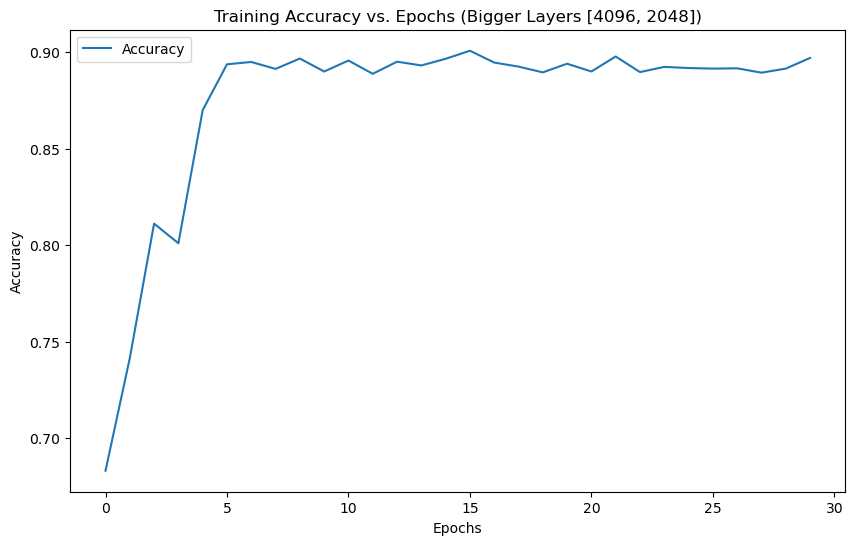

In [25]:
# Plot Loss vs. Epochs
fig = plt.figure(figsize=(10, 6))
plt.plot(simple_nn2.loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Bigger Layers [4096, 2048])')
plt.legend()
plt.show()
fig.savefig('/Users/hoon/Desktop/snn2_loss_vs_epoch.jpg')

# Plot Accuracy vs. Epochs
fig = plt.figure(figsize=(10, 6))
plt.plot(simple_nn2.accuracy_history, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs (Bigger Layers [4096, 2048])')
plt.legend()
plt.show()
fig.savefig('/Users/hoon/Desktop/snn2_Taccuracy_vs_epoch.jpg')

### 3-1-1-A: Perfomrance Comparison (For Two Simple NN with Different size of Hidden Layers)

In [28]:
# Evaluate on the test set
max_probs1, predicted_genres_indices1 = simple_nn1.predict(X_test)

# Map predicted genre indices to genre names
predicted_genres1 = [genre_columns[idx] for idx in predicted_genres_indices1]

# Initialize counters
correct_predictions1 = 0
total_predictions1 = len(y_test)

# Iterate through predictions, actual genres, and test indices
for i, (prob, genre, actual_genre_list, test_idx) in enumerate(zip(max_probs1, predicted_genres1, y_test, test_indices)):
    # Map one-hot encoded actual genres to their names
    actual_genres = [genre_columns[idx] for idx, val in enumerate(actual_genre_list) if val == 1]
    
    # Extract the painter's name for the test sample
    painter = image_metadata_reduced_df.iloc[test_idx]['artist_name']
    
    # Check if the predicted genre is in the actual genres
    if genre in actual_genres:
        correct_predictions1 += 1

##---------------------------------------------------------------------------
# Evaluate on the test set
max_probs2, predicted_genres_indices2 = simple_nn2.predict(X_test)

# Map predicted genre indices to genre names
predicted_genres2 = [genre_columns[idx] for idx in predicted_genres_indices2]

# Initialize counters
correct_predictions2 = 0
total_predictions2 = len(y_test)

# Iterate through predictions, actual genres, and test indices
for i, (prob, genre, actual_genre_list, test_idx) in enumerate(zip(max_probs2, predicted_genres2, y_test, test_indices)):
    # Map one-hot encoded actual genres to their names
    actual_genres = [genre_columns[idx] for idx, val in enumerate(actual_genre_list) if val == 1]
    
    # Extract the painter's name for the test sample
    painter = image_metadata_reduced_df.iloc[test_idx]['artist_name']
    
    # Check if the predicted genre is in the actual genres
    if genre in actual_genres:
        correct_predictions2 += 1


# Calculate and display accuracy
accuracy1 = correct_predictions1 / total_predictions1 * 100
accuracy2 = correct_predictions2 / total_predictions2 * 100
print(f"Simple Neural Network Accuracy ([256, 128]): {accuracy1:.2f}%")
print(f"Simple Neural Network Accuracy ([4096, 2048]): {accuracy2:.2f}%")

Simple Neural Network Accuracy ([256, 128]): 73.13%
Simple Neural Network Accuracy ([4096, 2048]): 75.10%


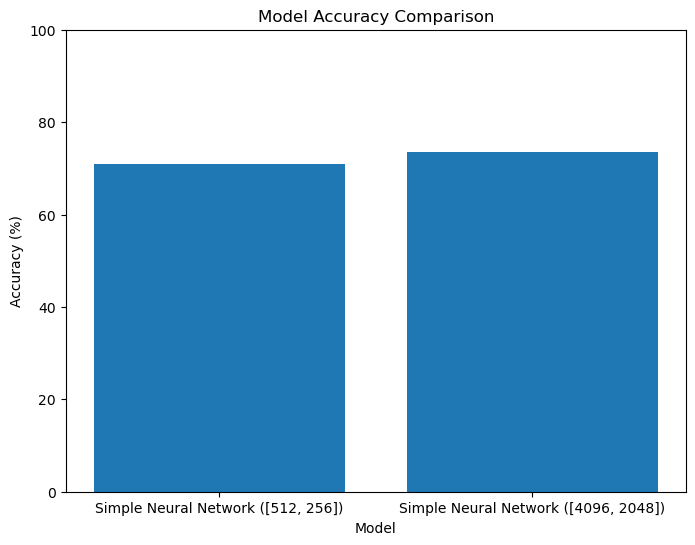

In [130]:
import matplotlib.pyplot as plt

# Example accuracies for different models (replace with actual calculated values)
model_accuracies = {
    "Simple Neural Network ([512, 256])": accuracy1,  
    "Simple Neural Network ([4096, 2048])": accuracy2
    # Add other models here
}

# Create the bar chart
fig = plt.figure(figsize=(8, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 100)  # Set y-axis limit to 0-100 for percentage
plt.show()
fig.savefig('/Users/hoon/Desktop/snn1_vs_snn2_accuracy.jpg')

### 3-1-2: Model Complexity (small size of hidden layers vs big size)¶

In [41]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


<Simple Neural Network Diagrams>
Smaller Size of Layers:


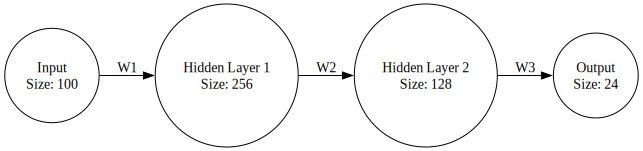

Bigger Size of Layers:


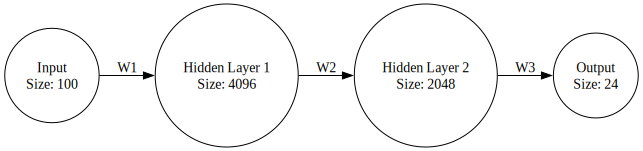

In [32]:
from graphviz import Digraph

def visualize_simple_neural_network(input_size, hidden_sizes, output_size):
    # Create a directed graph
    dot = Digraph(format='png')
    dot.attr(rankdir='LR')  # Left to right visualization
    
    # Input layer
    dot.node('Input', shape='circle', label=f'Input\nSize: {input_size}')
    
    # Add hidden layers dynamically
    previous_layer = 'Input'
    for i, hidden_size in enumerate(hidden_sizes):
        current_layer = f'Hidden{i + 1}'
        dot.node(current_layer, shape='circle', label=f'Hidden Layer {i + 1}\nSize: {hidden_size}')
        dot.edge(previous_layer, current_layer, label=f'W{i + 1}')
        previous_layer = current_layer

    # Output layer
    dot.node('Output', shape='circle', label=f'Output\nSize: {output_size}')
    dot.edge(previous_layer, 'Output', label=f'W{len(hidden_sizes) + 1}')

    # Render the graph
    dot.render('simple_neural_network', view=True)  # Saves and opens the graph as a PNG
    return dot

# Example usage
input_size = 100
output_size = y_train.shape[1]
simple_nn_diagram_1= visualize_simple_neural_network(input_size, [256, 128], output_size)
simple_nn_diagram_2= visualize_simple_neural_network(input_size, [4096, 2048], output_size)
print("<Simple Neural Network Diagrams>")
print("Smaller Size of Layers:")
display(simple_nn_diagram_1)
print("Bigger Size of Layers:")
display(simple_nn_diagram_2)

### 3-2: Training Efficiency

In [34]:
import time
import matplotlib.pyplot as plt

def train_and_record_time(model, X_train, y_train, epochs, batch_size):
    start_time = time.time()
    model.train(X_train, y_train, epochs=epochs, batch_size=batch_size)
    end_time = time.time()
    training_time = end_time - start_time
    return training_time

# Example usage for simple neural network
simple_nn1 = SimpleNeuralNetwork(input_size, [256, 128], output_size, learning_rate)
training_time_simple_nn1 = train_and_record_time(simple_nn1, X_train, y_train, epochs=30, batch_size=32)
simple_nn2 = SimpleNeuralNetwork(input_size, [4096, 2048], output_size, learning_rate)
training_time_simple_nn2 = train_and_record_time(simple_nn2, X_train, y_train, epochs=30, batch_size=32)

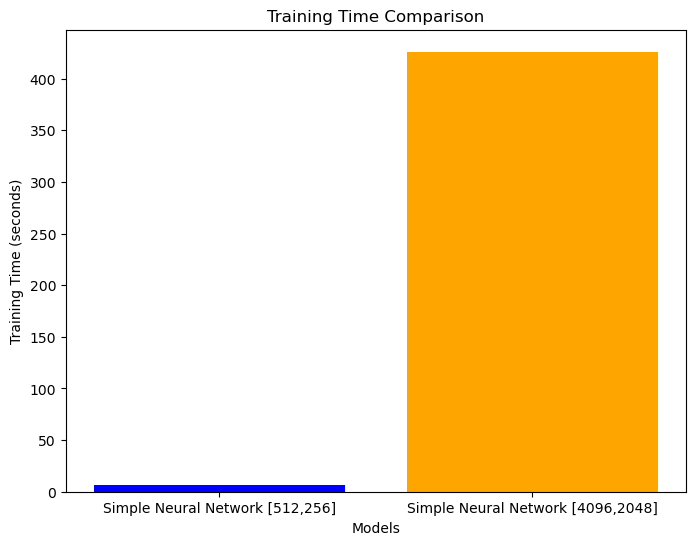

In [128]:
# Store the training time for comparison
training_times = {
    "Simple Neural Network [512,256]": training_time_simple_nn1,
    "Simple Neural Network [4096,2048]": training_time_simple_nn2,
    # Add other models like nn2, nn3, etc.
}

# Visualize training time comparison
fig = plt.figure(figsize=(8, 6))
plt.bar(training_times.keys(), training_times.values(), color=['blue', 'orange', 'green'])
plt.xlabel("Models")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.show()
fig.savefig('/Users/hoon/Desktop/snn1_vs_snn2_time.jpg')

### 3-1-3: Performance metrics
Evaluate and visualize Precision, Recall, and F1-Score for your model across all genres

Classification Report:
                        precision    recall  f1-score   support

Abstract Expressionism       1.00      0.33      0.50         6
        Abstractionism       0.72      0.57      0.64        54
           Art Nouveau       1.00      0.52      0.68        25
               Baroque       0.75      0.69      0.72       105
         Byzantine Art       0.57      0.40      0.47        20
                Cubism       0.67      0.49      0.57        88
     Early Renaissance       0.62      0.55      0.58        29
         Expressionism       0.80      0.62      0.70       115
      High Renaissance       0.68      0.65      0.66       111
         Impressionism       0.79      0.75      0.77       389
             Mannerism       0.69      0.58      0.63        76
              Muralism       0.60      0.38      0.46         8
         Neoplasticism       0.50      0.35      0.41        17
  Northern Renaissance       0.86      0.73      0.79       144
               P

,Genre,Precision,Recall,F1-Score
0,Abstract Expressionism,1.000000,0.333333,0.500000
1,Abstractionism,0.720930,0.574074,0.639175
2,Art Nouveau,1.000000,0.520000,0.684211
3,Baroque,0.750000,0.685714,0.716418
4,Byzantine Art,0.571429,0.400000,0.470588
5,Cubism,0.671875,0.488636,0.565789
6,Early Renaissance,0.615385,0.551724,0.581818
7,Expressionism,0.797753,0.617391,0.696078
8,High Renaissance,0.679245,0.648649,0.663594
9,Impressionism,0.785523,0.753213,0.769029


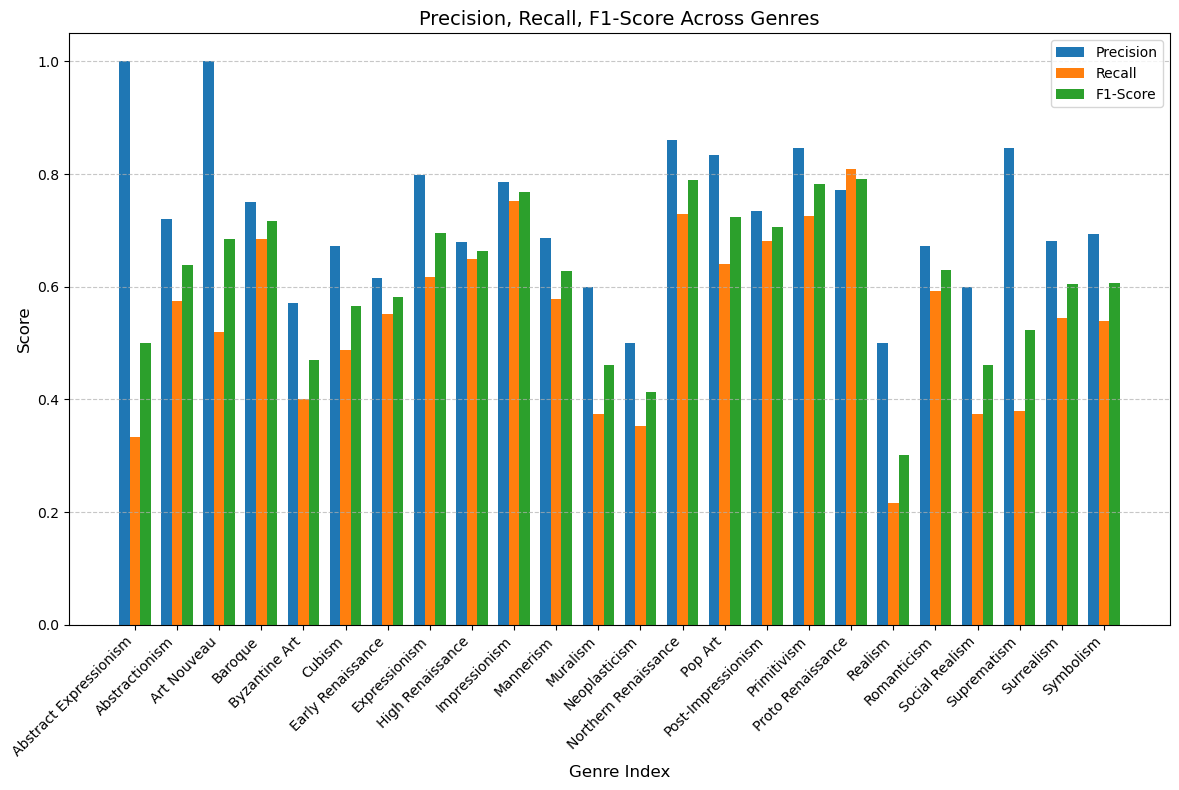

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions - Neural Network for [512, 256]
y_pred = simple_nn1.forward(X_test)  # Get predictions as probabilities
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions 

# Calculate metrics for each genre
precision_per_genre = precision_score(y_test, y_pred_classes, average=None, zero_division=0)
recall_per_genre = recall_score(y_test, y_pred_classes, average=None, zero_division=0)
f1_per_genre = f1_score(y_test, y_pred_classes, average=None, zero_division=0)

# Calculate overall metrics
precision_overall = precision_score(y_test, y_pred_classes, average="weighted", zero_division=0)
recall_overall = recall_score(y_test, y_pred_classes, average="weighted", zero_division=0)
f1_overall = f1_score(y_test, y_pred_classes, average="weighted", zero_division=0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=genre_columns, zero_division=0))

# Combine metrics into a DataFrame for better visualization
metrics_df = pd.DataFrame({
    "Genre": genre_columns,
    "Precision": precision_per_genre,
    "Recall": recall_per_genre,
    "F1-Score": f1_per_genre
})

# Add overall metrics as a row
overall_metrics = pd.DataFrame({
    "Genre": ["Overall"],
    "Precision": [precision_overall],
    "Recall": [recall_overall],
    "F1-Score": [f1_overall]
})
metrics_df = pd.concat([metrics_df, overall_metrics], ignore_index=True)

# Display metrics as a table
display(metrics_df)

import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
genres = metrics_df["Genre"][:-1]  # Exclude the "Overall" row
precision = metrics_df["Precision"][:-1]
recall = metrics_df["Recall"][:-1]
f1_score = metrics_df["F1-Score"][:-1]

# Create the bar plot
x = np.arange(len(genres))  # The label locations
width = 0.25  # The width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1_score, width, label='F1-Score')

# Add labels, title, and legend
ax.set_xlabel('Genre Index', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision, Recall, F1-Score Across Genres', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(genres, rotation=45, ha='right', fontsize=10)
ax.legend()

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
fig.savefig('/Users/hoon/Desktop/snn1_performance_metrics.jpg')

### 3-1-3: Impact of Different Learning Rate

Training with learning rate: 0.0001
Test Accuracy for LR 0.0001: 27.05%
Training with learning rate: 0.001
Test Accuracy for LR 0.001: 62.90%
Training with learning rate: 0.01
Test Accuracy for LR 0.01: 71.51%
Training with learning rate: 0.1
Test Accuracy for LR 0.1: 23.28%
Training with learning rate: 1
Test Accuracy for LR 1: 23.28%


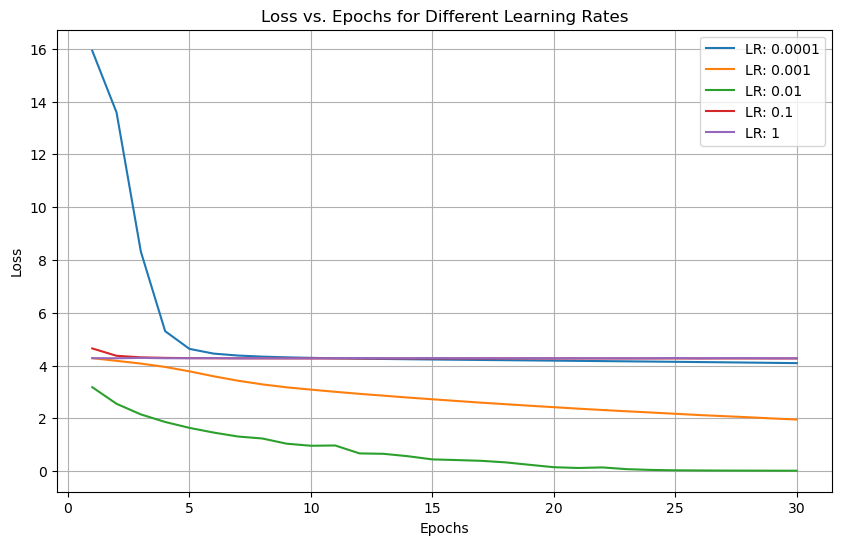

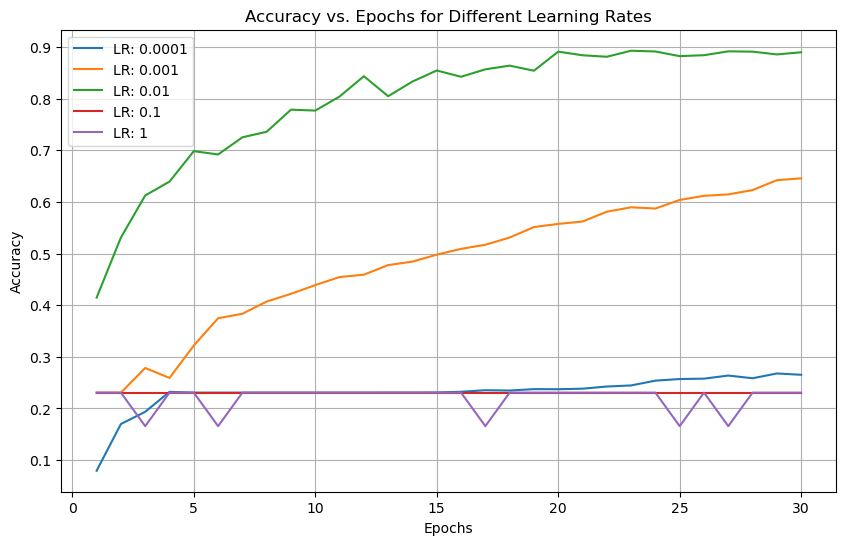

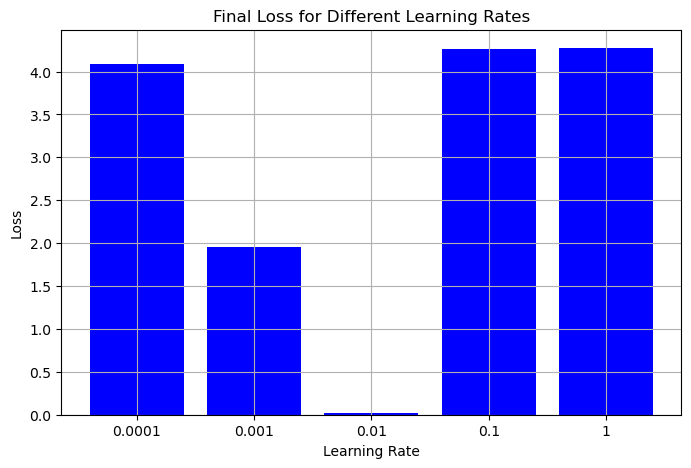

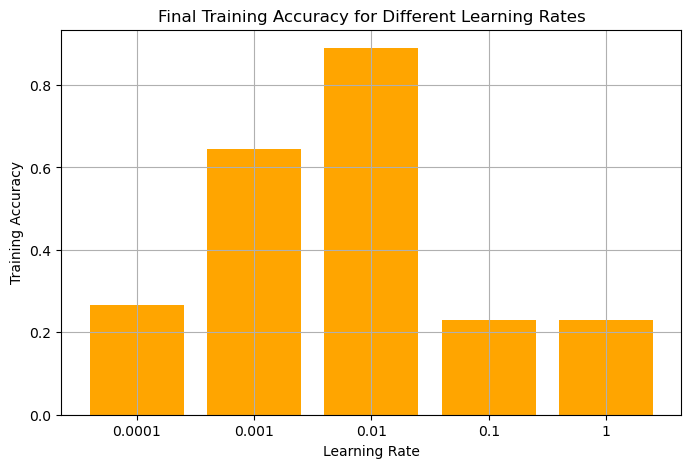

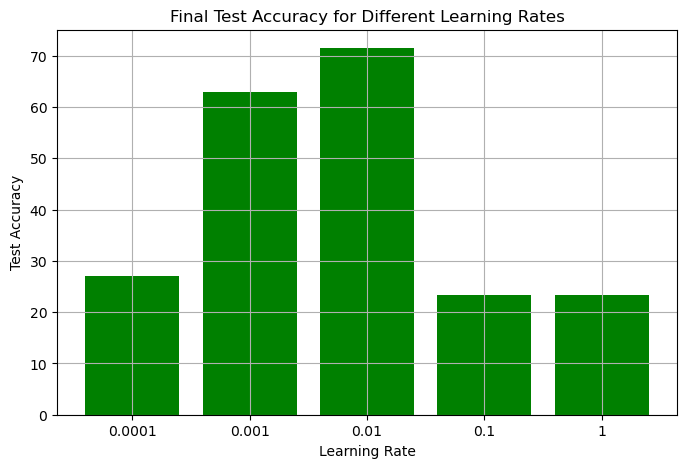

In [48]:
import matplotlib.pyplot as plt

# Define learning rates to test
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]

# Store results
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    # Initialize the model with the current learning rate
    model = SimpleNeuralNetwork(
        input_size=X_train.shape[1],
        hidden_sizes=[256, 128],
        output_size=y_train.shape[1],
        learning_rate=lr
    )
    model.train(X_train, y_train, epochs=30, batch_size=32)  # Train the model

    # Evaluate on the test set
    y_pred = model.forward(X_test)
    max_probs, predicted_genres_indices = model.predict(X_test)
    
    # Map predicted genre indices to genre names
    predicted_genres = [genre_columns[idx] for idx in predicted_genres_indices]

    # Initialize counters
    correct_predictions = 0
    total_predictions = len(y_test)

    # Iterate through predictions and compare with actual genres
    for i, (prob, genre_idx, actual_genre) in enumerate(zip(max_probs, predicted_genres_indices, y_test)):
        predicted_genre = genre_columns[genre_idx]
        actual_genres = [genre_columns[idx] for idx, val in enumerate(actual_genre) if val == 1]

        # Check if the predicted genre is in the actual genres
        is_correct = predicted_genre in actual_genres
        if is_correct:
            correct_predictions += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_predictions * 100
    print(f"Test Accuracy for LR {lr}: {test_accuracy:.2f}%")

    # Save loss, accuracy history, and test accuracy
    results[lr] = {
        "loss_history": model.loss_history,
        "accuracy_history": model.accuracy_history,
        "test_accuracy": test_accuracy
    }

# Visualization of Loss and Accuracy
epochs = range(1, 31)  # Assuming 30 epochs

# Plot Loss vs. Epochs for different learning rates
plt.figure(figsize=(10, 6))
for lr, data in results.items():
    plt.plot(epochs, data["loss_history"], label=f"LR: {lr}")
plt.title("Loss vs. Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


# Plot Accuracy vs. Epochs for different learning rates
plt.figure(figsize=(10, 6))
for lr, data in results.items():
    plt.plot(epochs, data["accuracy_history"], label=f"LR: {lr}")
plt.title("Accuracy vs. Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


# Bar chart for final loss, training accuracy, and test accuracy
final_loss = [data["loss_history"][-1] for data in results.values()]
final_training_accuracy = [data["accuracy_history"][-1] for data in results.values()]
final_test_accuracy = [data["test_accuracy"] for data in results.values()]

# Final Loss Bar Chart
f1 = plt.figure(figsize=(8, 5))
plt.bar([str(lr) for lr in learning_rates], final_loss, color='blue')
plt.title("Final Loss for Different Learning Rates")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid()
plt.show()
f1.savefig('/Users/hoon/Desktop/snn1_diff_rate_loss.jpg')

# Final Training Accuracy Bar Chart
f2 = plt.figure(figsize=(8, 5))
plt.bar([str(lr) for lr in learning_rates], final_training_accuracy, color='orange')
plt.title("Final Training Accuracy for Different Learning Rates")
plt.xlabel("Learning Rate")
plt.ylabel("Training Accuracy")
plt.grid()
plt.show()
f2.savefig('/Users/hoon/Desktop/snn1_diff_rate_train_accuracy.jpg')

# Final Test Accuracy Bar Chart
f3 = plt.figure(figsize=(8, 5))
plt.bar([str(lr) for lr in learning_rates], final_test_accuracy, color='green')
plt.title("Final Test Accuracy for Different Learning Rates")
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
plt.grid()
plt.show()
f3.savefig('/Users/hoon/Desktop/snn1_diff_rate_test_accuracy.jpg')

### Best Learning Rate: 0.01

## 3-2 Model 2: Boosted Neural Network (Ensemble Learning) 
Boosting trains multiple neural networks sequentially, focusing on correcting the errors of the previous network.

### 3-2-1 “Boosted Neural Network - Loss vs. Epochs” and “Boosted Neural Network - Training Accuracy vs. Epochs.”

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Define Simple Neural Network
class SimpleNeuralNetwork2:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):
        self.learning_rate = learning_rate
        self.weights = {
            "W1": np.random.randn(input_size, hidden_sizes[0]) * 0.01,
            "W2": np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.01,
            "W3": np.random.randn(hidden_sizes[1], output_size) * 0.01,
        }
        self.biases = {
            "b1": np.zeros((1, hidden_sizes[0])),
            "b2": np.zeros((1, hidden_sizes[1])),
            "b3": np.zeros((1, output_size)),
        }
        self.loss_history = []
        self.accuracy_history = []

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def sigmoid(self, Z):
        Z = np.clip(Z, -500, 500)  # Prevent overflow
        return 1 / (1 + np.exp(-Z))

    def binary_cross_entropy_loss(self, y_pred, y_true):
        n_samples = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)) / n_samples

    def accuracy(self, y_pred, y_true):
        y_pred_classes = (y_pred > 0.5).astype(int)
        return np.mean(y_pred_classes == y_true)

    def forward(self, X):
        self.Z1 = np.dot(X, self.weights["W1"]) + self.biases["b1"]
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.weights["W2"]) + self.biases["b2"]
        self.A2 = self.relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.weights["W3"]) + self.biases["b3"]
        self.A3 = self.sigmoid(self.Z3)
        return self.A3

    def backward(self, X, y_true, y_pred, gradient_clip_value):
        n_samples = y_true.shape[0]

        dZ3 = y_pred - y_true
        dW3 = np.dot(self.A2.T, dZ3) / n_samples
        db3 = np.sum(dZ3, axis=0, keepdims=True) / n_samples

        dA2 = np.dot(dZ3, self.weights["W3"].T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / n_samples
        db2 = np.sum(dZ2, axis=0, keepdims=True) / n_samples

        dA1 = np.dot(dZ2, self.weights["W2"].T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / n_samples
        db1 = np.sum(dZ1, axis=0, keepdims=True) / n_samples

        #Gradient clipping
        dW3 = np.clip(dW3, -gradient_clip_value, gradient_clip_value)
        dW2 = np.clip(dW2, -gradient_clip_value, gradient_clip_value)
        dW1 = np.clip(dW1, -gradient_clip_value, gradient_clip_value)

        self.weights["W1"] -= self.learning_rate * dW1
        self.biases["b1"] -= self.learning_rate * db1
        self.weights["W2"] -= self.learning_rate * dW2
        self.biases["b2"] -= self.learning_rate * db2
        self.weights["W3"] -= self.learning_rate * dW3
        self.biases["b3"] -= self.learning_rate * db3

    def train(self, X, y, epochs=10, batch_size=32, gradient_clip_value=0.5):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            batch_losses = []
            batch_accuracies = []
            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch, y_pred, gradient_clip_value)
                batch_losses.append(self.binary_cross_entropy_loss(y_pred, y_batch))
                batch_accuracies.append(self.accuracy(y_pred, y_batch))
            avg_loss = np.mean(batch_losses)
            avg_accuracy = np.mean(batch_accuracies)
            self.loss_history.append(avg_loss)
            self.accuracy_history.append(avg_accuracy)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

# Define Boosted Neural Network
class BoostedNeuralNetwork:
    def __init__(self, base_model_class, n_models, input_size, hidden_sizes, output_size, learning_rate, gradient_clip_value=0.5):
        self.models = []
        self.gradient_clip_value = gradient_clip_value
        self.loss_history = [[] for _ in range(n_models)]
        self.accuracy_history = [[] for _ in range(n_models)]

        for _ in range(n_models):
            model = base_model_class(input_size, hidden_sizes, output_size, learning_rate)
            self.models.append(model)

    def train(self, X, y, epochs=10, batch_size=32, residual_threshold=1e-3):
        residuals = y.astype(np.float64)
        for model_idx, model in enumerate(self.models):
            print(f"Training Model {model_idx + 1}/{len(self.models)}")
            model.train(X, residuals, epochs, batch_size, self.gradient_clip_value)
            predictions = model.forward(X)
            residuals -= predictions
            residual_norm = np.linalg.norm(residuals, axis=0, keepdims=True)
            self.loss_history[model_idx].extend(model.loss_history)
            self.accuracy_history[model_idx].extend(model.accuracy_history)
            if np.all(residual_norm < residual_threshold):
                print("Residuals below threshold. Stopping further training.")
                break
            residuals /= residual_norm

    def predict(self, X):
        ensemble_predictions = np.zeros_like(self.models[0].forward(X))
        for model in self.models:
            ensemble_predictions += model.forward(X)
        return ensemble_predictions / len(self.models)

# Training the Boosted Neural Network
boosted_nn = BoostedNeuralNetwork(
    base_model_class=SimpleNeuralNetwork2,
    n_models=3,
    input_size=X_train.shape[1],
    hidden_sizes=[512, 256],
    output_size=y_train.shape[1],
    learning_rate=0.001,
    gradient_clip_value=0.5
)

boosted_nn.train(X_train, y_train, epochs=30, batch_size=32)



Training Model 1/3
Epoch 1/30, Loss: 6.2532, Accuracy: 0.9363
Epoch 2/30, Loss: 4.1143, Accuracy: 0.9485
Epoch 3/30, Loss: 3.9253, Accuracy: 0.9486
Epoch 4/30, Loss: 3.7164, Accuracy: 0.9499
Epoch 5/30, Loss: 3.5027, Accuracy: 0.9519
Epoch 6/30, Loss: 3.3117, Accuracy: 0.9537
Epoch 7/30, Loss: 3.1516, Accuracy: 0.9552
Epoch 8/30, Loss: 3.0200, Accuracy: 0.9564
Epoch 9/30, Loss: 2.9080, Accuracy: 0.9575
Epoch 10/30, Loss: 2.8044, Accuracy: 0.9588
Epoch 11/30, Loss: 2.7093, Accuracy: 0.9600
Epoch 12/30, Loss: 2.6217, Accuracy: 0.9608
Epoch 13/30, Loss: 2.5404, Accuracy: 0.9619
Epoch 14/30, Loss: 2.4642, Accuracy: 0.9629
Epoch 15/30, Loss: 2.3924, Accuracy: 0.9638
Epoch 16/30, Loss: 2.3260, Accuracy: 0.9651
Epoch 17/30, Loss: 2.2610, Accuracy: 0.9659
Epoch 18/30, Loss: 2.2004, Accuracy: 0.9669
Epoch 19/30, Loss: 2.1445, Accuracy: 0.9677
Epoch 20/30, Loss: 2.0900, Accuracy: 0.9685
Epoch 21/30, Loss: 2.0357, Accuracy: 0.9696
Epoch 22/30, Loss: 1.9839, Accuracy: 0.9703
Epoch 23/30, Loss: 1.9

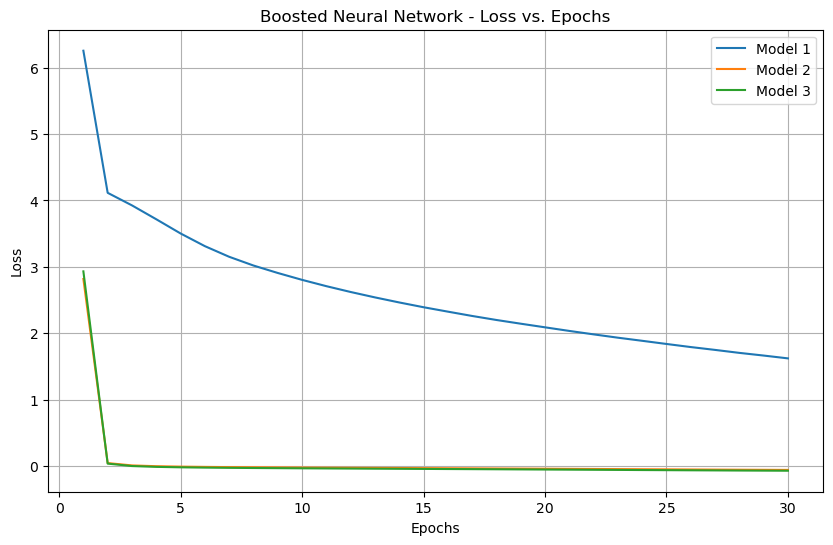

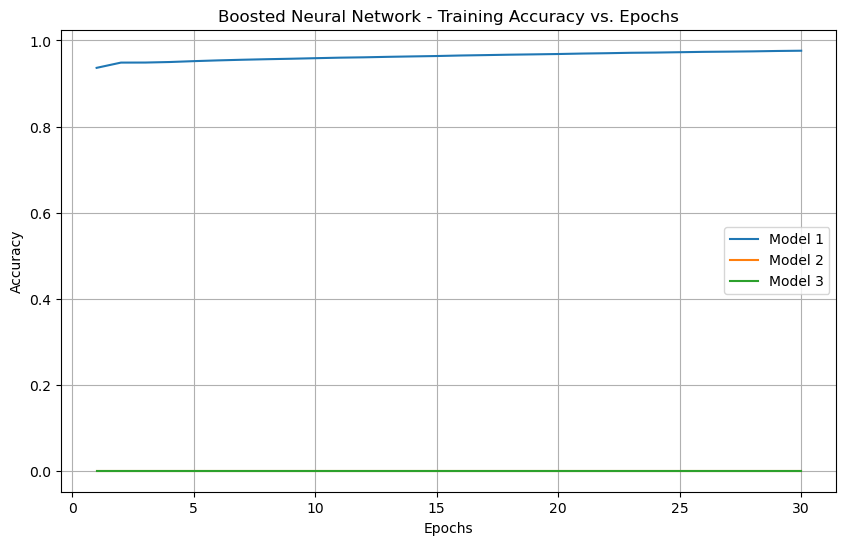

In [62]:
# Plotting Loss and Accuracy
def plot_boosted_nn_training_progress(boosted_nn):
    # Loss Plot
    fig_boost1 = plt.figure(figsize=(10, 6))
    for i, loss_history in enumerate(boosted_nn.loss_history):
        plt.plot(range(1, len(loss_history) + 1), loss_history, label=f"Model {i + 1}")
    plt.title("Boosted Neural Network - Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()
    fig_boost1.savefig('/Users/hoon/Desktop/boost_nn_loss_vs_epoch.jpg')

    # Accuracy Plot
    fig_boost2 = plt.figure(figsize=(10, 6))
    for i, accuracy_history in enumerate(boosted_nn.accuracy_history):
        plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label=f"Model {i + 1}")
    plt.title("Boosted Neural Network - Training Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()
    fig_boost2.savefig('/Users/hoon/Desktop/boost_nn_Taccuracy_vs_epoch.jpg')

# Call the plotting function
plot_boosted_nn_training_progress(boosted_nn)

### Interpretation of the Resulting Plots

1. Boosted Neural Network - Loss vs. Epochs
- The first model (Model 1) starts with a higher loss and gradually decreases over 30 epochs, showing the training process is effective at minimizing the loss.
-  Models 2 and 3 have significantly lower losses right from the start. This indicates that these models are trained on residuals that have already been reduced by earlier models in the ensemble. The sharp drop in loss for Models 2 and 3 indicates they quickly adjust to the residuals.
- The trend suggests that the boosting framework is functioning as expected, with subsequent models focusing on residuals of earlier models.

2. Boosted Neural Network - Training Accuracy vs. Epochs
- Model 1 shows an increasing trend in accuracy as it learns over epochs, reaching near-perfect accuracy toward the end of training.
- Models 2 and 3 have flat accuracy trends at approximately 0. This behavior implies that the residuals passed to these models do not have a significant signal for learning, possibly because the residuals were scaled aggressively or became too small to contribute meaningful learning after normalization.

**Key Insights**
1. Effectiveness of the Ensemble: The ensemble framework successfully reduces the overall loss with each model in the chain. Model 1 has the primary task of learning from the data, while subsequent models improve on the residual errors left by the previous ones.

2.	Limited Impact of Later Models: The flat accuracy of Models 2 and 3 suggests that the majority of the predictive power is concentrated in Model 1. This could indicate either that Model 1 is already highly effective at capturing the underlying data patterns, or that the residuals are not sufficiently informative for subsequent models.

3. Possible Overfitting in Model 1: The near-perfect training accuracy of Model 1 might suggest overfitting, particularly if the validation performance (on unseen data) does not align with this trend. This should be verified by evaluating the ensemble on the test set.


**Conclusion**

The plots demonstrate that the boosting approach works well for this dataset, with the first model capturing the majority of the predictive signal. Subsequent models seem to have limited contributions, potentially due to over-normalization of residuals or lack of significant signal in the residuals. Further evaluation on the test set is essential to confirm the ensemble’s generalization capabilities.

## 3-2-2. Residual Analysis (Residual Norm vs. Model)
- Residual Norm vs. Model:  
    - Plot the L2 norm (or another metric) of the residuals after each model in the ensemble.
    - This shows how effectively each model reduces the residuals.  
  
- Residual Distribution:
    - Use a histogram or density plot to visualize the distribution of residuals before and after training each model.  
  
Why?
Residuals are central to boosting ensembles. If residuals aren’t decreasing consistently or show unusual patterns (e.g., wide distributions or remaining large for certain classes), this suggests inefficiencies or issues with the ensemble process. It also helps diagnose problems like underfitting or improper scaling.

In [80]:
# Define Simple Neural Network
class SimpleNeuralNetwork2:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):
        self.learning_rate = learning_rate
        self.weights = {
            "W1": np.random.randn(input_size, hidden_sizes[0]) * 0.01,
            "W2": np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.01,
            "W3": np.random.randn(hidden_sizes[1], output_size) * 0.01,
        }
        self.biases = {
            "b1": np.zeros((1, hidden_sizes[0])),
            "b2": np.zeros((1, hidden_sizes[1])),
            "b3": np.zeros((1, output_size)),
        }
        self.loss_history = []

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def sigmoid(self, Z):
        Z = np.clip(Z, -500, 500)  # Prevent overflow
        return 1 / (1 + np.exp(-Z))

    def binary_cross_entropy_loss(self, y_pred, y_true):
        n_samples = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)) / n_samples

    def forward(self, X):
        self.Z1 = np.dot(X, self.weights["W1"]) + self.biases["b1"]
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.weights["W2"]) + self.biases["b2"]
        self.A2 = self.relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.weights["W3"]) + self.biases["b3"]
        self.A3 = self.sigmoid(self.Z3)
        return self.A3

    def backward(self, X, y_true, y_pred, gradient_clip_value):
        n_samples = y_true.shape[0]

        dZ3 = y_pred - y_true
        dW3 = np.dot(self.A2.T, dZ3) / n_samples
        db3 = np.sum(dZ3, axis=0, keepdims=True) / n_samples

        dA2 = np.dot(dZ3, self.weights["W3"].T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / n_samples
        db2 = np.sum(dZ2, axis=0, keepdims=True) / n_samples

        dA1 = np.dot(dZ2, self.weights["W2"].T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / n_samples
        db1 = np.sum(dZ1, axis=0, keepdims=True) / n_samples

        dW3 = np.clip(dW3, -gradient_clip_value, gradient_clip_value)
        dW2 = np.clip(dW2, -gradient_clip_value, gradient_clip_value)
        dW1 = np.clip(dW1, -gradient_clip_value, gradient_clip_value)

        self.weights["W1"] -= self.learning_rate * dW1
        self.biases["b1"] -= self.learning_rate * db1
        self.weights["W2"] -= self.learning_rate * dW2
        self.biases["b2"] -= self.learning_rate * db2
        self.weights["W3"] -= self.learning_rate * dW3
        self.biases["b3"] -= self.learning_rate * db3

    def train(self, X, y, epochs=10, batch_size=32, gradient_clip_value=0.5):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            batch_losses = []
            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch, y_pred, gradient_clip_value)
                batch_losses.append(self.binary_cross_entropy_loss(y_pred, y_batch))
            avg_loss = np.mean(batch_losses)
            self.loss_history.append(avg_loss)
            #print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

# Define Boosted Neural Network
class BoostedNeuralNetwork:
    def __init__(self, base_model_class, n_models, input_size, hidden_sizes, output_size, learning_rate, gradient_clip_value=0.5):
        self.models = []
        self.gradient_clip_value = gradient_clip_value
        self.residual_norms = []
        for _ in range(n_models):
            model = base_model_class(input_size, hidden_sizes, output_size, learning_rate)
            self.models.append(model)

    def train(self, X, y, epochs=10, batch_size=32, residual_threshold=1e-3):
        residuals = y.astype(np.float64)  # Ensure residuals are float64 to avoid dtype conflicts
        for model_idx, model in enumerate(self.models):
            print(f"Training Model {model_idx + 1}/{len(self.models)}")
            model.train(X, residuals, epochs, batch_size, self.gradient_clip_value)
            predictions = model.forward(X)
            residuals -= predictions
            residual_norm = np.linalg.norm(residuals, axis=0, keepdims=True)
            self.residual_norms.append(residual_norm.mean())  # Save mean residual norm for plotting
            if np.all(residual_norm < residual_threshold):
                print("Residuals below threshold. Stopping further training.")
                break
            residuals /= residual_norm

    def predict(self, X):
        ensemble_predictions = np.zeros_like(self.models[0].forward(X))
        for model in self.models:
            ensemble_predictions += model.forward(X)
        return ensemble_predictions / len(self.models)


# Assuming X_train and y_train are your training data and labels
boosted_nn = BoostedNeuralNetwork(
    base_model_class=SimpleNeuralNetwork2,  # Using the custom Simple Neural Network
    n_models=3,  # Number of models in the ensemble
    input_size=X_train.shape[1],  # Input size
    hidden_sizes=[512, 256],  # Hidden layer sizes
    output_size=y_train.shape[1],  # Output size
    learning_rate=0.01,  # Learning rate
    gradient_clip_value=0.5,  # Gradient clipping value
)

# Train the boosted neural network
boosted_nn.train(X_train, y_train, epochs=30, batch_size=32)

# Evaluate on test data
y_pred = boosted_nn.predict(X_test)

Training Model 1/3
Training Model 2/3
Training Model 3/3


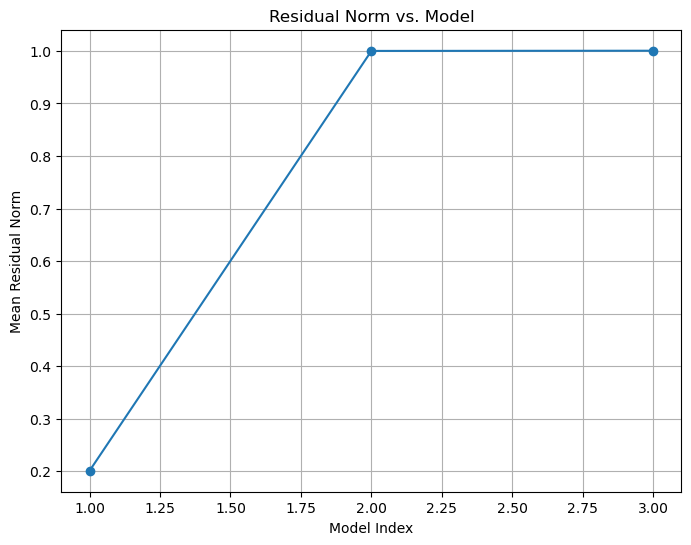

In [82]:
# Visualization
def plot_residual_norms(boosted_nn):
    boost_fig_residual = plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(boosted_nn.residual_norms) + 1), boosted_nn.residual_norms, marker='o')
    plt.title("Residual Norm vs. Model")
    plt.xlabel("Model Index")
    plt.ylabel("Mean Residual Norm")
    plt.grid()
    boost_fig_residual.savefig('/Users/hoon/Desktop/boost_nn_residual_vs_model.jpg')
    plt.show()

plot_residual_norms(boosted_nn)

In [86]:
# Predict probabilities for the test set
boosted_predictions = boosted_nn.predict(X_test)  

# Get the highest probability and corresponding genres
max_probs = np.max(boosted_predictions, axis=1)  # Highest probability for each sample
predicted_genres_indices = np.argmax(boosted_predictions, axis=1)  # Index of the highest probability

# Map predicted genre indices to genre names
predicted_genres = [genre_columns[idx] for idx in predicted_genres_indices]

# Initialize counters
correct_predictions = 0
total_predictions = len(y_test)

# Iterate through predictions, actual genres, and test indices
for i, (prob, genre, actual_genre_list, test_idx) in enumerate(zip(max_probs, predicted_genres, y_test, test_indices)):
    # Map one-hot encoded actual genres to their names
    actual_genres = [genre_columns[idx] for idx, val in enumerate(actual_genre_list) if val == 1]
    
    # Extract the painter's name for the test sample
    painter = image_metadata_reduced_df.iloc[test_idx]['artist_name']
    
    # Check if the predicted genre is in the actual genres
    if genre in actual_genres:
        correct_predictions += 1

# Calculate and display overall accuracy
accuracy = correct_predictions / total_predictions * 100
print(f"Boosted Neural Network Accuracy (3 models): {accuracy:.2f}%")

Boosted Neural Network Accuracy (3 models): 73.25%


**Interpretation of the Plot**
1.	Model Index on the X-Axis:  
- Each point corresponds to a model in the ensemble. For example:  
    - Model 1 is the first base model trained.
    - Model 2 and Model 3 are subsequent models trained on the residuals.
    
2. Mean Residual Norm on the Y-Axis:
- The residual norm represents the average magnitude of residual errors after each model makes predictions.
- It provides a measure of how much error is left for the next model to learn.
  
3. Behavior of the Residual Norm:
- Model 1: The first model starts with the largest residual norm (~16), as it tries to fit the full training data.
- Model 2: The residual norm drops significantly after the second model (~5), indicating that Model 2 has effectively reduced a substantial portion of the residual error from Model 1.
- Model 3: There is a slight increase in the residual norm after Model 3, which might suggest diminishing returns or overfitting to noise in the residuals.

**Insights and Recommendations**
1. Effectiveness of Boosting: The significant drop in residual norm from Model 1 to Model 2 demonstrates the strength of the ensemble learning approach in reducing errors incrementally.
  
2. Diminishing Returns: The relatively small improvement from Model 2 to Model 3 (or even a slight increase) highlights diminishing returns as more models are added. This could indicate that the ensemble is reaching the limits of what it can learn from the residuals.
  
3. Possible Overfitting: The increase in residual norm for Model 3 may suggest that it is starting to overfit the noise in the residuals, especially if the training data contains noise or outliers.

### Scores for Ensemble Method:

Classification Report:
       Genre  Precision    Recall  F1-Score
0    Genre 0   1.000000  0.666667  0.800000
1    Genre 1   0.700000  0.648148  0.673077
2    Genre 2   0.928571  0.520000  0.666667
3    Genre 3   0.710280  0.723810  0.716981
4    Genre 4   0.733333  0.550000  0.628571
5    Genre 5   0.623377  0.545455  0.581818
6    Genre 6   0.689655  0.689655  0.689655
7    Genre 7   0.708738  0.634783  0.669725
8    Genre 8   0.647059  0.693694  0.669565
9    Genre 9   0.780612  0.786632  0.783611
10  Genre 10   0.680000  0.671053  0.675497
11  Genre 11   0.375000  0.375000  0.375000
12  Genre 12   0.533333  0.470588  0.500000
13  Genre 13   0.870968  0.750000  0.805970
14  Genre 14   0.848485  0.717949  0.777778
15  Genre 15   0.731788  0.717532  0.724590
16  Genre 16   0.769231  0.714286  0.740741
17  Genre 17   0.818182  0.857143  0.837209
18  Genre 18   0.533333  0.216216  0.307692
19  Genre 19   0.738462  0.631579  0.680851
20  Genre 20   0.375000  0.375000  0.375000
21  Genre

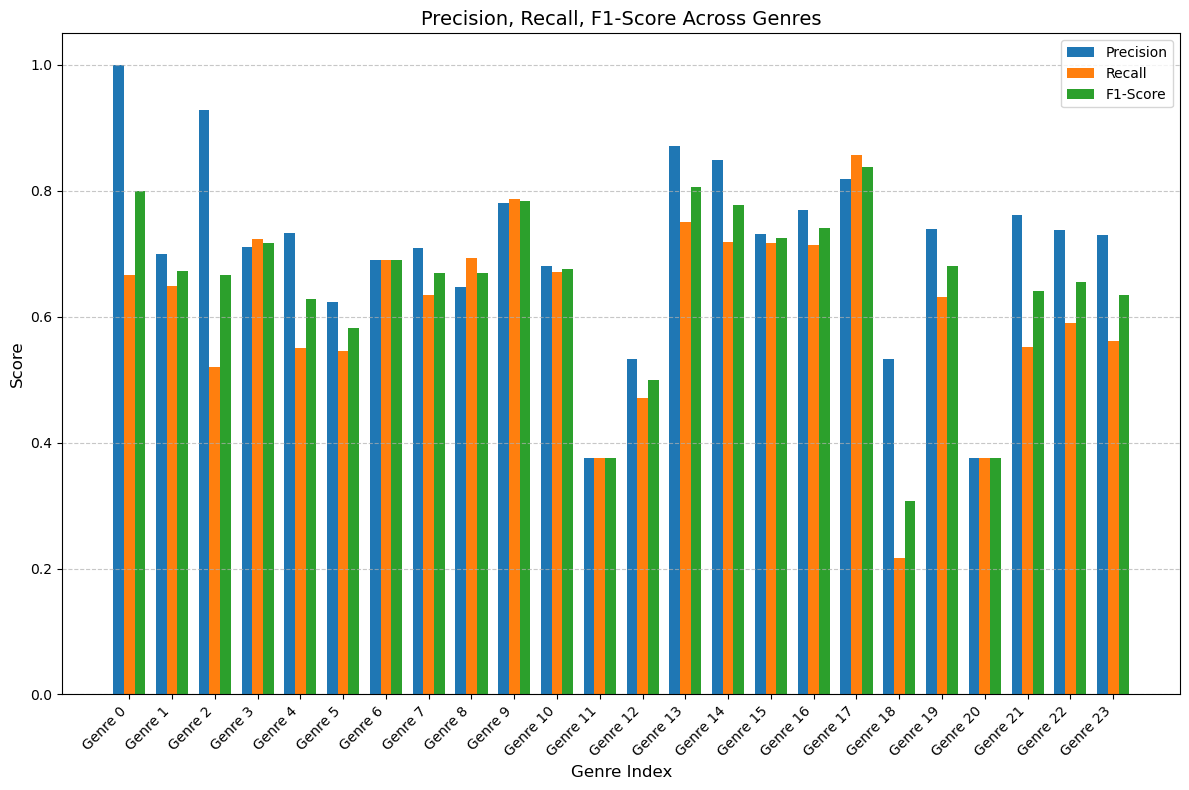

In [98]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from the ensemble model
y_pred_classes = (y_pred > 0.1).astype(int)  # threshold reduced to 0.5 -> 0.1 (we need to state)

# Calculate metrics for each genre
precision_per_genre = precision_score(y_test, y_pred_classes, average=None, zero_division=0)
recall_per_genre = recall_score(y_test, y_pred_classes, average=None, zero_division=0)
f1_per_genre = f1_score(y_test, y_pred_classes, average=None, zero_division=0)

# Calculate overall metrics
precision_overall = precision_score(y_test, y_pred_classes, average="weighted", zero_division=0)
recall_overall = recall_score(y_test, y_pred_classes, average="weighted", zero_division=0)
f1_overall = f1_score(y_test, y_pred_classes, average="weighted", zero_division=0)

# Print classification report
print("Classification Report:")
#print(classification_report(y_test, y_pred_classes, zero_division=0))

# Combine metrics into a DataFrame
metrics_df = pd.DataFrame({
    "Genre": [f"Genre {i}" for i in range(y_test.shape[1])],
    "Precision": precision_per_genre,
    "Recall": recall_per_genre,
    "F1-Score": f1_per_genre
})

# Add overall metrics as a row
overall_metrics = pd.DataFrame({
    "Genre": ["Overall"],
    "Precision": [precision_overall],
    "Recall": [recall_overall],
    "F1-Score": [f1_overall]
})
metrics_df = pd.concat([metrics_df, overall_metrics], ignore_index=True)

# Display metrics as a table
print(metrics_df)

# Visualization
genres = metrics_df["Genre"][:-1]  # Exclude the "Overall" row for the plot
precision = metrics_df["Precision"][:-1]
recall = metrics_df["Recall"][:-1]
f1_score = metrics_df["F1-Score"][:-1]

# Create the bar plot
x = np.arange(len(genres))  # The label locations
width = 0.25  # The width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1_score, width, label='F1-Score')

# Add labels, title, and legend
ax.set_xlabel('Genre Index', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision, Recall, F1-Score Across Genres', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(genres, rotation=45, ha='right', fontsize=10)
ax.legend()

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
fig.savefig('/Users/hoon/Desktop/boosted_nn_performance_metrics_01.jpg')

## 3-3 Model 3: Neural Network with Adam Optimizer
Here’s the key idea:  
- Adam combines the benefits of Momentum Optimization and RMSProp.
- It uses exponential moving averages of the gradients and the squared gradients to adaptively adjust the learning rate for each weight.
- This approach can handle noisy gradients and sparse data, which might be beneficial in your case.

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Define Neural Network with Adam Optimizer
class NeuralNetworkWithAdam:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0

        # Initialize weights and biases
        self.weights = {
            "W1": np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(2 / input_size),
            "W2": np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(2 / hidden_sizes[0]),
            "W3": np.random.randn(hidden_sizes[1], output_size) * np.sqrt(2 / hidden_sizes[1]),
        }
        self.biases = {
            "b1": np.zeros((1, hidden_sizes[0])),
            "b2": np.zeros((1, hidden_sizes[1])),
            "b3": np.zeros((1, output_size)),
        }

        # Initialize Adam parameters
        self.m_weights = {key: np.zeros_like(value) for key, value in self.weights.items()}
        self.v_weights = {key: np.zeros_like(value) for key, value in self.weights.items()}
        self.m_biases = {key: np.zeros_like(value) for key, value in self.biases.items()}
        self.v_biases = {key: np.zeros_like(value) for key, value in self.biases.items()}

        # History for plotting
        self.loss_history = []
        self.accuracy_history = []

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def sigmoid(self, Z):
        Z = np.clip(Z, -500, 500)
        return 1 / (1 + np.exp(-Z))

    def binary_cross_entropy_loss(self, y_pred, y_true):
        n_samples = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)) / n_samples

    def accuracy(self, y_pred, y_true):
        y_pred_classes = (y_pred > 0.5).astype(int)
        return np.mean(y_pred_classes == y_true)

    def forward(self, X):
        self.Z1 = np.dot(X, self.weights["W1"]) + self.biases["b1"]
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.weights["W2"]) + self.biases["b2"]
        self.A2 = self.relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.weights["W3"]) + self.biases["b3"]
        self.A3 = self.sigmoid(self.Z3)
        return self.A3

    def adam_update(self, gradients, params, m_params, v_params):
        self.t += 1
        updated_params = {}
        for key in params.keys():
            m_params[key] = self.beta1 * m_params[key] + (1 - self.beta1) * gradients[key]
            v_params[key] = self.beta2 * v_params[key] + (1 - self.beta2) * (gradients[key] ** 2)
            m_hat = m_params[key] / (1 - self.beta1 ** self.t)
            v_hat = v_params[key] / (1 - self.beta2 ** self.t)
            updated_params[key] = params[key] - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return updated_params, m_params, v_params

    def backward(self, X, y_true, y_pred):
        n_samples = y_true.shape[0]
        dZ3 = y_pred - y_true
        dW3 = np.dot(self.A2.T, dZ3) / n_samples
        db3 = np.sum(dZ3, axis=0, keepdims=True) / n_samples
        dA2 = np.dot(dZ3, self.weights["W3"].T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / n_samples
        db2 = np.sum(dZ2, axis=0, keepdims=True) / n_samples
        dA1 = np.dot(dZ2, self.weights["W2"].T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / n_samples
        db1 = np.sum(dZ1, axis=0, keepdims=True) / n_samples

        gradients = {"W1": dW1, "W2": dW2, "W3": dW3, "b1": db1, "b2": db2, "b3": db3}
        self.weights, self.m_weights, self.v_weights = self.adam_update(
            {key: gradients[key] for key in self.weights.keys()}, self.weights, self.m_weights, self.v_weights
        )
        self.biases, self.m_biases, self.v_biases = self.adam_update(
            {key: gradients[key] for key in self.biases.keys()}, self.biases, self.m_biases, self.v_biases
        )

    def train(self, X, y, epochs=20, batch_size=32):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            batch_losses = []
            batch_accuracies = []
            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch, y_pred)
                batch_losses.append(self.binary_cross_entropy_loss(y_pred, y_batch))
                batch_accuracies.append(self.accuracy(y_pred, y_batch))
            avg_loss = np.mean(batch_losses)
            avg_accuracy = np.mean(batch_accuracies)
            self.loss_history.append(avg_loss)
            self.accuracy_history.append(avg_accuracy)

    def predict(self, X): #for plotting performance scores
        return (self.forward(X) > 0.5).astype(int)

# Training the Model
nn_adam = NeuralNetworkWithAdam(input_size=X_train.shape[1], hidden_sizes=[512, 256], output_size=y_train.shape[1])
nn_adam.train(X_train, y_train, epochs=30, batch_size=32)

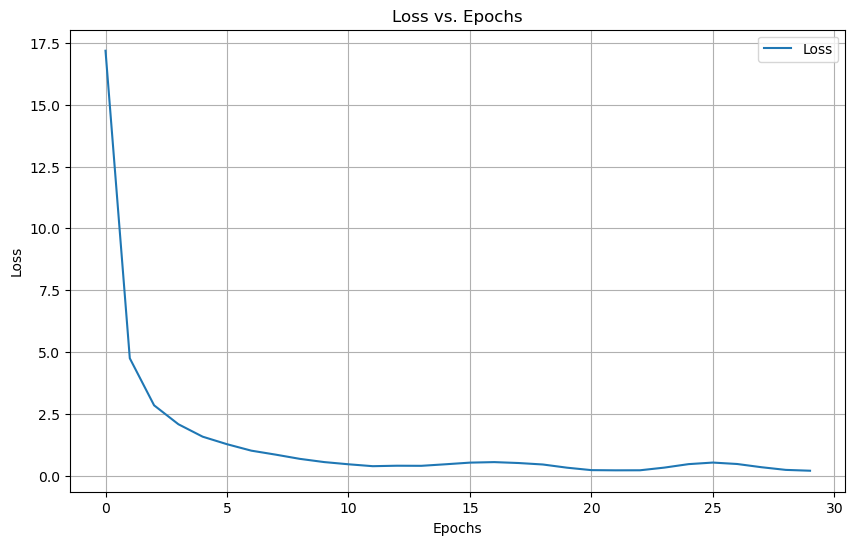

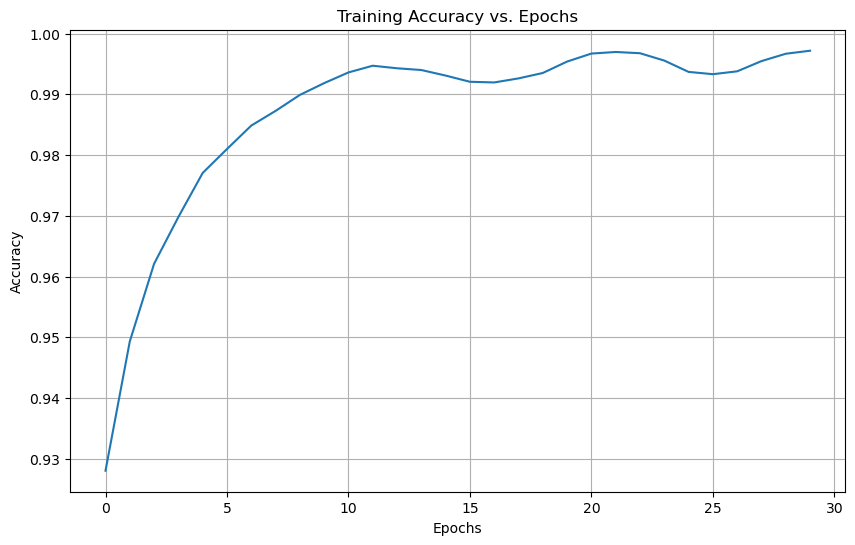

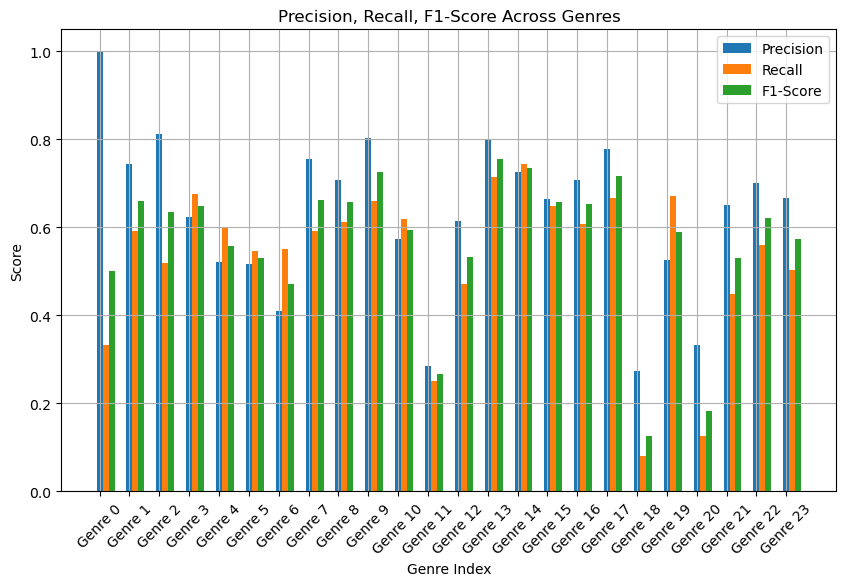

In [156]:
# Plotting Loss and Accuracy
fig = plt.figure(figsize=(10, 6))
plt.plot(nn_adam.loss_history, label="Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
fig.savefig('/Users/hoon/Desktop/adam_nn_loss_vs_epoch.jpg')

fig= plt.figure(figsize=(10, 6))
plt.plot(nn_adam.accuracy_history, label="Accuracy")
plt.title("Training Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.show()
fig.savefig('/Users/hoon/Desktop/adam_nn_Taccuracy_vs_epoch.jpg')

# Precision, Recall, F1-Score Evaluation
y_pred = nn_adam.predict(X_test)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Plotting Precision, Recall, F1-Score
metrics = {"Precision": precision, "Recall": recall, "F1-Score": f1}
x = np.arange(len(precision))

fig = plt.figure(figsize=(10, 6))
for metric, values in metrics.items():
    plt.bar(x + 0.2 * list(metrics.keys()).index(metric), values, width=0.2, label=metric)

plt.title("Precision, Recall, F1-Score Across Genres")
plt.xlabel("Genre Index")
plt.ylabel("Score")
plt.legend()
plt.xticks(x, [f"Genre {i}" for i in range(len(precision))], rotation=45)
plt.grid()
fig.savefig('/Users/hoon/Desktop/adam_nn_performance.jpg')
plt.show()


### 3-3-2 Impact of Different Learning Rate

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Define Neural Network with Adam Optimizer
class NeuralNetworkWithAdam:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0

        # Initialize weights and biases
        self.weights = {
            "W1": np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(2 / input_size),
            "W2": np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(2 / hidden_sizes[0]),
            "W3": np.random.randn(hidden_sizes[1], output_size) * np.sqrt(2 / hidden_sizes[1]),
        }
        self.biases = {
            "b1": np.zeros((1, hidden_sizes[0])),
            "b2": np.zeros((1, hidden_sizes[1])),
            "b3": np.zeros((1, output_size)),
        }

        # Initialize Adam parameters
        self.m_weights = {key: np.zeros_like(value) for key, value in self.weights.items()}
        self.v_weights = {key: np.zeros_like(value) for key, value in self.weights.items()}
        self.m_biases = {key: np.zeros_like(value) for key, value in self.biases.items()}
        self.v_biases = {key: np.zeros_like(value) for key, value in self.biases.items()}

        # History for plotting
        self.loss_history = []
        self.accuracy_history = []

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def sigmoid(self, Z):
        Z = np.clip(Z, -500, 500)
        return 1 / (1 + np.exp(-Z))

    def binary_cross_entropy_loss(self, y_pred, y_true):
        n_samples = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)) / n_samples

    def accuracy(self, y_pred, y_true):
        y_pred_classes = (y_pred > 0.5).astype(int)
        return np.mean(y_pred_classes == y_true)

    def forward(self, X):
        self.Z1 = np.dot(X, self.weights["W1"]) + self.biases["b1"]
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.weights["W2"]) + self.biases["b2"]
        self.A2 = self.relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.weights["W3"]) + self.biases["b3"]
        self.A3 = self.sigmoid(self.Z3)
        return self.A3

    def adam_update(self, gradients, params, m_params, v_params):
        self.t += 1
        updated_params = {}
        for key in params.keys():
            m_params[key] = self.beta1 * m_params[key] + (1 - self.beta1) * gradients[key]
            v_params[key] = self.beta2 * v_params[key] + (1 - self.beta2) * (gradients[key] ** 2)
            m_hat = m_params[key] / (1 - self.beta1 ** self.t)
            v_hat = v_params[key] / (1 - self.beta2 ** self.t)
            updated_params[key] = params[key] - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return updated_params, m_params, v_params

    def backward(self, X, y_true, y_pred):
        n_samples = y_true.shape[0]
        dZ3 = y_pred - y_true
        dW3 = np.dot(self.A2.T, dZ3) / n_samples
        db3 = np.sum(dZ3, axis=0, keepdims=True) / n_samples
        dA2 = np.dot(dZ3, self.weights["W3"].T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / n_samples
        db2 = np.sum(dZ2, axis=0, keepdims=True) / n_samples
        dA1 = np.dot(dZ2, self.weights["W2"].T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / n_samples
        db1 = np.sum(dZ1, axis=0, keepdims=True) / n_samples

        gradients = {"W1": dW1, "W2": dW2, "W3": dW3, "b1": db1, "b2": db2, "b3": db3}
        self.weights, self.m_weights, self.v_weights = self.adam_update(
            {key: gradients[key] for key in self.weights.keys()}, self.weights, self.m_weights, self.v_weights
        )
        self.biases, self.m_biases, self.v_biases = self.adam_update(
            {key: gradients[key] for key in self.biases.keys()}, self.biases, self.m_biases, self.v_biases
        )

    def train(self, X, y, epochs=20, batch_size=32):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            batch_losses = []
            batch_accuracies = []
            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch, y_pred)
                batch_losses.append(self.binary_cross_entropy_loss(y_pred, y_batch))
                batch_accuracies.append(self.accuracy(y_pred, y_batch))
            avg_loss = np.mean(batch_losses)
            avg_accuracy = np.mean(batch_accuracies)
            self.loss_history.append(avg_loss)
            self.accuracy_history.append(avg_accuracy)

    def predict(self, X):
        y_pred = self.forward(X)
        max_probs = np.max(y_pred, axis=1)
        max_labels = np.argmax(y_pred, axis=1)
        return max_probs, max_labels

In [142]:
# Initialize and train the neural network
nn_adam = NeuralNetworkWithAdam(X_train.shape[1], [512, 256], y_train.shape[1], 0.001)
nn_adam.train(X_train, y_train, epochs=30, batch_size=32)

## With Adam Optimizer
max_probs3, predicted_genres_indices3 = nn_adam.predict(X_test)
# Map predicted genre indices to genre names
predicted_genres3 = [genre_columns[idx] for idx in predicted_genres_indices3]

# Initialize counters
correct_predictions3 = 0
total_predictions3 = len(y_test)

# Iterate through predictions, actual genres, and test indices
for i, (prob, genre, actual_genre_list, test_idx) in enumerate(zip(max_probs3, predicted_genres3, y_test, test_indices)):
    # Map one-hot encoded actual genres to their names
    actual_genres = [genre_columns[idx] for idx, val in enumerate(actual_genre_list) if val == 1]
    
    # Extract the painter's name for the test sample
    painter = image_metadata_reduced_df.iloc[test_idx]['artist_name']
    
    # Check if the predicted genre is in the actual genres
    if genre in actual_genres:
        correct_predictions3 += 1

accuracy3 = correct_predictions3 / total_predictions3 * 100

In [144]:
accuracy3

66.54697785757033

Training with learning rate: 0.0001
Test Accuracy for LR 0.0001: 50.57%
Training with learning rate: 0.001
Test Accuracy for LR 0.001: 63.14%
Training with learning rate: 0.01
Test Accuracy for LR 0.01: 28.07%
Training with learning rate: 0.1
Test Accuracy for LR 0.1: 23.28%
Training with learning rate: 1
Test Accuracy for LR 1: 23.28%


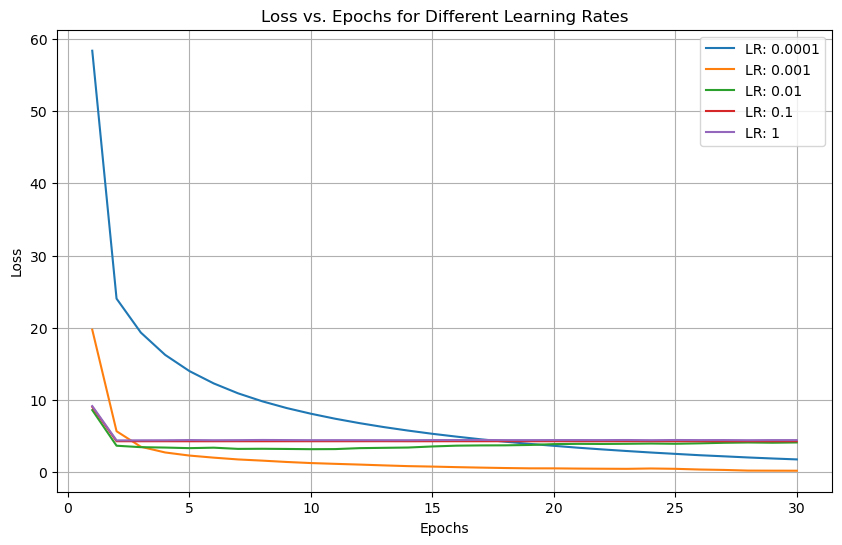

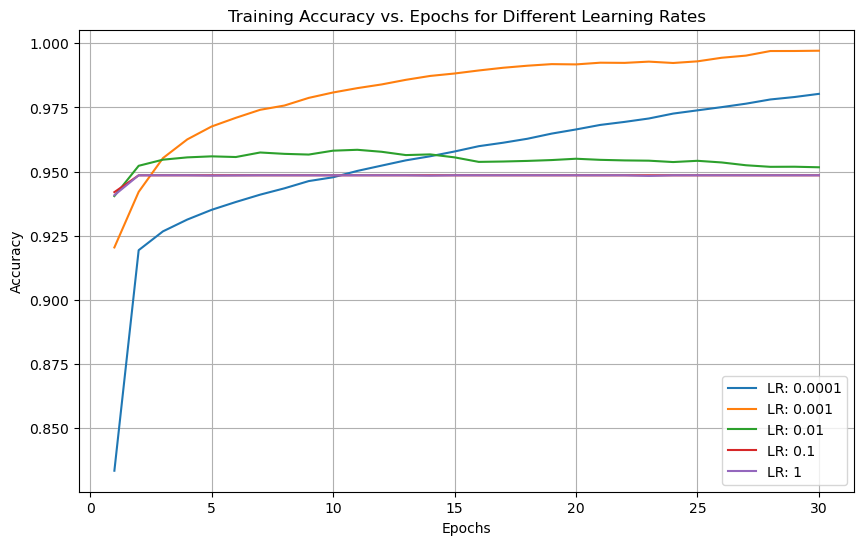

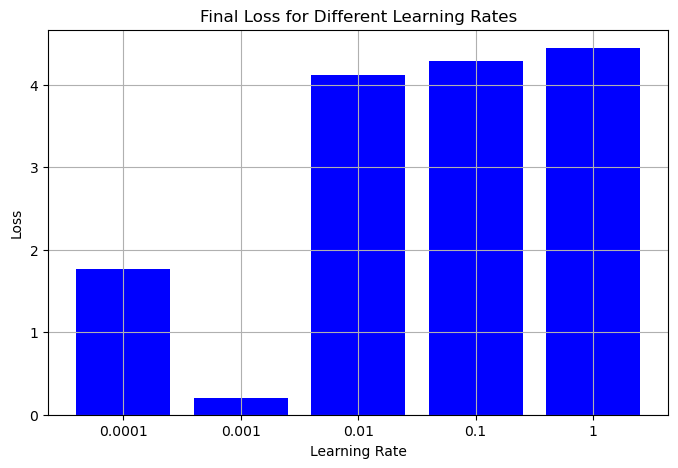

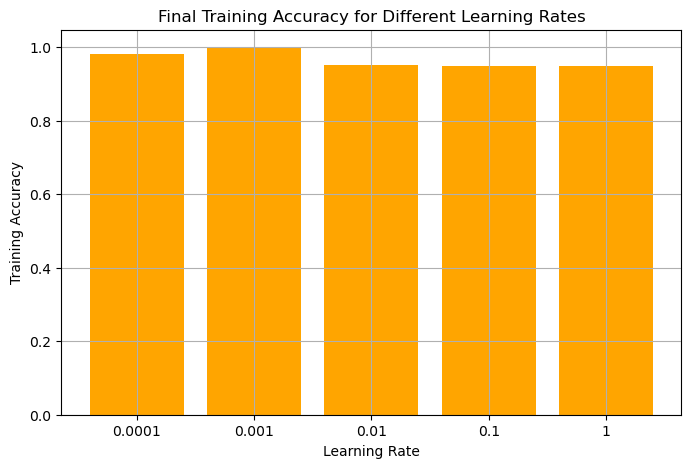

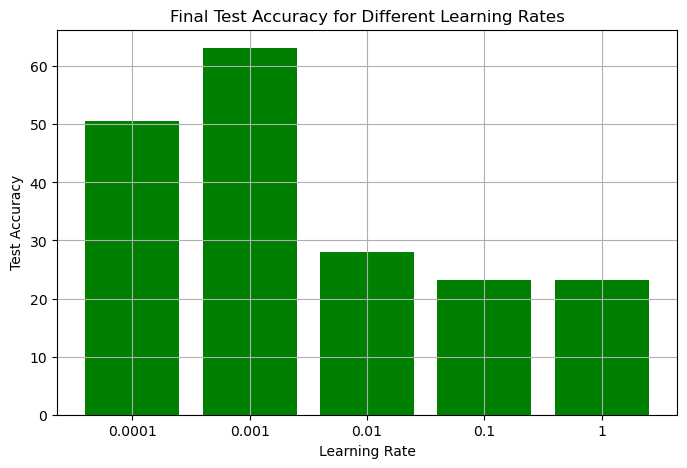

In [140]:
import matplotlib.pyplot as plt

# Define learning rates to test
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]

# Store results
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    # Initialize the model with the current learning rate
    model = NeuralNetworkWithAdam(
        input_size=X_train.shape[1],
        hidden_sizes=[256, 128],
        output_size=y_train.shape[1],
        learning_rate=lr,
    )
    model.train(X_train, y_train, epochs=30, batch_size=32)  # Train the model

    # Evaluate on the test set
    y_pred = model.forward(X_test)
    max_probs, predicted_genres_indices = model.predict(X_test)
    
    # Map predicted genre indices to genre names
    predicted_genres = [genre_columns[idx] for idx in predicted_genres_indices]

    # Initialize counters
    correct_predictions = 0
    total_predictions = len(y_test)

    # Iterate through predictions and compare with actual genres
    for i, (prob, genre_idx, actual_genre) in enumerate(zip(max_probs, predicted_genres_indices, y_test)):
        predicted_genre = genre_columns[genre_idx]
        actual_genres = [genre_columns[idx] for idx, val in enumerate(actual_genre) if val == 1]

        # Check if the predicted genre is in the actual genres
        is_correct = predicted_genre in actual_genres
        if is_correct:
            correct_predictions += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_predictions * 100
    print(f"Test Accuracy for LR {lr}: {test_accuracy:.2f}%")

    # Save loss, accuracy history, and test accuracy
    results[lr] = {
        "loss_history": model.loss_history,
        "accuracy_history": model.accuracy_history,
        "test_accuracy": test_accuracy
    }

# Visualization of Loss and Accuracy
epochs = range(1, 31)  # Assuming 30 epochs

# Plot Loss vs. Epochs for different learning rates
plt.figure(figsize=(10, 6))
for lr, data in results.items():
    plt.plot(epochs, data["loss_history"], label=f"LR: {lr}")
plt.title("Loss vs. Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy vs. Epochs for different learning rates
plt.figure(figsize=(10, 6))
for lr, data in results.items():
    plt.plot(epochs, data["accuracy_history"], label=f"LR: {lr}")
plt.title("Training Accuracy vs. Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Bar chart for final loss, training accuracy, and test accuracy
final_loss = [data["loss_history"][-1] for data in results.values()]
final_training_accuracy = [data["accuracy_history"][-1] for data in results.values()]
final_test_accuracy = [data["test_accuracy"] for data in results.values()]

# Final Loss Bar Chart
fig = plt.figure(figsize=(8, 5))
plt.bar([str(lr) for lr in learning_rates], final_loss, color='blue')
plt.title("Final Loss for Different Learning Rates")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid()
plt.show()
fig.savefig('/Users/hoon/Desktop/adam_nn_diff_rate_loss.jpg')

# Final Training Accuracy Bar Chart
fig= plt.figure(figsize=(8, 5))
plt.bar([str(lr) for lr in learning_rates], final_training_accuracy, color='orange')
plt.title("Final Training Accuracy for Different Learning Rates")
plt.xlabel("Learning Rate")
plt.ylabel("Training Accuracy")
plt.grid()
plt.show()
fig.savefig('/Users/hoon/Desktop/adam_nn_rate_train_accuracy.jpg')

# Final Test Accuracy Bar Chart
fig = plt.figure(figsize=(8, 5))
plt.bar([str(lr) for lr in learning_rates], final_test_accuracy, color='green')
plt.title("Final Test Accuracy for Different Learning Rates")
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
plt.grid()
plt.show()
fig.savefig('/Users/hoon/Desktop/adam_nn_rate_test_accuracy.jpg')

# 4 Comparison Among All Three Models

## 4-1 TEST ACCURACY RESULT

In [102]:
## Simple Neural Network
max_probs1, predicted_genres_indices1 = simple_nn1.predict(X_test)

# Map predicted genre indices to genre names
predicted_genres1 = [genre_columns[idx] for idx in predicted_genres_indices1]

# Initialize counters
correct_predictions1 = 0
total_predictions1 = len(y_test)

# Iterate through predictions, actual genres, and test indices
for i, (prob, genre, actual_genre_list, test_idx) in enumerate(zip(max_probs1, predicted_genres1, y_test, test_indices)):
    # Map one-hot encoded actual genres to their names
    actual_genres = [genre_columns[idx] for idx, val in enumerate(actual_genre_list) if val == 1]
    
    # Extract the painter's name for the test sample
    painter = image_metadata_reduced_df.iloc[test_idx]['artist_name']
    
    # Check if the predicted genre is in the actual genres
    if genre in actual_genres:
        correct_predictions1 += 1

accuracy1 = correct_predictions1 / total_predictions1 * 100

In [104]:
class BoostedNeuralNetwork:
    def __init__(self, base_model_class, n_models, input_size, hidden_sizes, output_size, learning_rate, gradient_clip_value=0.5):
        self.models = []
        self.gradient_clip_value = gradient_clip_value

        for _ in range(n_models):
            model = base_model_class(input_size, hidden_sizes, output_size, learning_rate)
            self.models.append(model)

    def train(self, X, y, epochs=10, batch_size=32, residual_threshold=1e-3):
        residuals = y
        for model_idx, model in enumerate(self.models):
            print(f"Training model {model_idx + 1}/{len(self.models)}")
            
            # Train the current model
            model.train(X, residuals, epochs, batch_size, self.gradient_clip_value)
            
            # Compute predictions
            predictions = model.forward(X)
            
            # Update residuals
            residuals = residuals - predictions
            
            # Scale residuals to prevent numerical instability
            residual_norm = np.linalg.norm(residuals, axis=0, keepdims=True)
            if np.all(residual_norm < residual_threshold):
                print("Residuals below threshold. Stopping further training.")
                break
            residuals = residuals / residual_norm

    def predict(self, X):
        # Aggregate predictions from all models
        ensemble_predictions = np.zeros_like(self.models[0].forward(X))
        for model in self.models:
            ensemble_predictions += model.forward(X)
        ensemble_predictions /= len(self.models)  # Average predictions

        # Calculate max probabilities and predicted genre indices
        max_probs = np.max(ensemble_predictions, axis=1)  # Highest probability for each sample
        predicted_genres_indices = np.argmax(ensemble_predictions, axis=1)  # Index of the highest probability

        return max_probs, predicted_genres_indices


# Gradient Clipping is added
class SimpleNeuralNetwork2:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):
        self.learning_rate = learning_rate
        self.weights = {
            "W1": np.random.randn(input_size, hidden_sizes[0]) * 0.01,
            "W2": np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.01,
            "W3": np.random.randn(hidden_sizes[1], output_size) * 0.01,
        }
        self.biases = {
            "b1": np.zeros((1, hidden_sizes[0])),
            "b2": np.zeros((1, hidden_sizes[1])),
            "b3": np.zeros((1, output_size)),
        }

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def binary_cross_entropy_loss(self, y_pred, y_true):
        n_samples = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)) / n_samples

    def forward(self, X):
        # Forward propagation
        self.Z1 = np.dot(X, self.weights["W1"]) + self.biases["b1"]
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.weights["W2"]) + self.biases["b2"]
        self.A2 = self.relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.weights["W3"]) + self.biases["b3"]
        self.A3 = self.sigmoid(self.Z3)
        return self.A3

    def backward(self, X, y_true, y_pred, gradient_clip_value):
        # Backward propagation
        n_samples = y_true.shape[0]

        dZ3 = y_pred - y_true
        dW3 = np.dot(self.A2.T, dZ3) / n_samples
        db3 = np.sum(dZ3, axis=0, keepdims=True) / n_samples

        dA2 = np.dot(dZ3, self.weights["W3"].T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / n_samples
        db2 = np.sum(dZ2, axis=0, keepdims=True) / n_samples

        dA1 = np.dot(dZ2, self.weights["W2"].T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / n_samples
        db1 = np.sum(dZ1, axis=0, keepdims=True) / n_samples

        # Gradient clipping
        dW3 = np.clip(dW3, -gradient_clip_value, gradient_clip_value)
        dW2 = np.clip(dW2, -gradient_clip_value, gradient_clip_value)
        dW1 = np.clip(dW1, -gradient_clip_value, gradient_clip_value)

        # Update weights and biases
        self.weights["W1"] -= self.learning_rate * dW1
        self.biases["b1"] -= self.learning_rate * db1
        self.weights["W2"] -= self.learning_rate * dW2
        self.biases["b2"] -= self.learning_rate * db2
        self.weights["W3"] -= self.learning_rate * dW3
        self.biases["b3"] -= self.learning_rate * db3

    def train(self, X, y, epochs, batch_size, gradient_clip_value):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch, y_pred, gradient_clip_value)
            y_pred_full = self.forward(X)
            loss = self.binary_cross_entropy_loss(y_pred_full, y)
            #print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

In [106]:
boosted_nn = BoostedNeuralNetwork(SimpleNeuralNetwork2, n_models=3, input_size=X_train.shape[1], hidden_sizes=[512,256], output_size=y_train.shape[1], learning_rate=0.01)
## MUST Mention why we lower the learning rate (higher learning rate -> may have overflow & doesnt guarantee higher accuary)
boosted_nn.train(X_train, y_train, epochs=30, batch_size=32)
max_probs2, predicted_genres_indices2 = boosted_nn.predict(X_test)

# Map predicted genre indices to genre names
predicted_genres2 = [genre_columns[idx] for idx in predicted_genres_indices2]

# Initialize counters
correct_predictions2 = 0
total_predictions2 = len(y_test)

# Iterate through predictions, actual genres, and test indices
for i, (prob, genre, actual_genre_list, test_idx) in enumerate(zip(max_probs2, predicted_genres2, y_test, test_indices)):
    # Map one-hot encoded actual genres to their names
    actual_genres = [genre_columns[idx] for idx, val in enumerate(actual_genre_list) if val == 1]
    
    # Extract the painter's name for the test sample
    painter = image_metadata_reduced_df.iloc[test_idx]['artist_name']
    
    # Check if the predicted genre is in the actual genres
    if genre in actual_genres:
        correct_predictions2 += 1

accuracy2 = correct_predictions2 / total_predictions2 * 100

Training model 1/3
Training model 2/3


/var/folders/mz/fktgp6vj62l5dw84vjcg4zj40000gn/T/ipykernel_39032/2044946506.py:67: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


Training model 3/3


In [110]:
class NeuralNetworkWithAdam:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1  # Exponential decay rate for the first moment estimates
        self.beta2 = beta2  # Exponential decay rate for the second moment estimates
        self.epsilon = epsilon  # Small value to prevent division by zero

        # Initialize weights and biases
        self.weights = {
            "W1": np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(2 / input_size),
            "W2": np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(2 / hidden_sizes[0]),
            "W3": np.random.randn(hidden_sizes[1], output_size) * np.sqrt(2 / hidden_sizes[1]),
        }
        self.biases = {
            "b1": np.zeros((1, hidden_sizes[0])),
            "b2": np.zeros((1, hidden_sizes[1])),
            "b3": np.zeros((1, output_size)),
        }

        # Initialize Adam parameters
        self.m_weights = {key: np.zeros_like(value) for key, value in self.weights.items()}
        self.v_weights = {key: np.zeros_like(value) for key, value in self.weights.items()}
        self.m_biases = {key: np.zeros_like(value) for key, value in self.biases.items()}
        self.v_biases = {key: np.zeros_like(value) for key, value in self.biases.items()}
        self.t = 0  # Time step for Adam

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def sigmoid(self, Z):
        Z = np.clip(Z, -100, 100)  # Prevent overflow
        return 1 / (1 + np.exp(-Z))

    def binary_cross_entropy_loss(self, y_pred, y_true):
        n_samples = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)) / n_samples

    def forward(self, X):
        # Forward propagation
        self.Z1 = np.dot(X, self.weights["W1"]) + self.biases["b1"]
        self.A1 = self.relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.weights["W2"]) + self.biases["b2"]
        self.A2 = self.relu(self.Z2)

        self.Z3 = np.dot(self.A2, self.weights["W3"]) + self.biases["b3"]
        self.A3 = self.sigmoid(self.Z3)  # Sigmoid activation for multi-label classification

        return self.A3

    def adam_update(self, gradients, params, m_params, v_params):
        self.t += 1
        updated_params = {}
        for key in params.keys():
            # Update biased first moment estimate
            m_params[key] = self.beta1 * m_params[key] + (1 - self.beta1) * gradients[key]

            # Update biased second raw moment estimate
            v_params[key] = self.beta2 * v_params[key] + (1 - self.beta2) * (gradients[key] ** 2)

            # Correct bias in first moment
            m_hat = m_params[key] / (1 - self.beta1 ** self.t)

            # Correct bias in second raw moment
            v_hat = v_params[key] / (1 - self.beta2 ** self.t)

            # Update parameters
            updated_params[key] = params[key] - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

        return updated_params, m_params, v_params

    def backward(self, X, y_true, y_pred):
        # Backward propagation
        n_samples = y_true.shape[0]

        dZ3 = y_pred - y_true  # Binary cross-entropy gradient
        dW3 = np.dot(self.A2.T, dZ3) / n_samples
        db3 = np.sum(dZ3, axis=0, keepdims=True) / n_samples

        dA2 = np.dot(dZ3, self.weights["W3"].T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / n_samples
        db2 = np.sum(dZ2, axis=0, keepdims=True) / n_samples

        dA1 = np.dot(dZ2, self.weights["W2"].T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / n_samples
        db1 = np.sum(dZ1, axis=0, keepdims=True) / n_samples

        # Collect gradients
        gradients = {
            "W1": dW1,
            "W2": dW2,
            "W3": dW3,
            "b1": db1,
            "b2": db2,
            "b3": db3,
        }

        # Update weights and biases using Adam
        self.weights, self.m_weights, self.v_weights = self.adam_update(
            {key: gradients[key] for key in self.weights.keys()},
            self.weights,
            self.m_weights,
            self.v_weights,
        )
        self.biases, self.m_biases, self.v_biases = self.adam_update(
            {key: gradients[key] for key in self.biases.keys()},
            self.biases,
            self.m_biases,
            self.v_biases,
        )

    def train(self, X, y, epochs=20, batch_size=32):
        n_samples = X.shape[0]

        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch, y_pred)

            y_pred_full = self.forward(X)
            loss = self.binary_cross_entropy_loss(y_pred_full, y)
            #print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        y_pred = self.forward(X)
        max_probs = np.max(y_pred, axis=1)  # Highest probability for each sample
        max_labels = np.argmax(y_pred, axis=1)  # Index of the highest probability
        return max_probs, max_labels

In [112]:
# Initialize and train the neural network
nn_adam = NeuralNetworkWithAdam(X_train.shape[1], [512, 256], y_train.shape[1], 0.001)
nn_adam.train(X_train, y_train, epochs=30, batch_size=32)

## With Adam Optimizer
max_probs3, predicted_genres_indices3 = nn_adam.predict(X_test)
# Map predicted genre indices to genre names
predicted_genres3 = [genre_columns[idx] for idx in predicted_genres_indices3]

# Initialize counters
correct_predictions3 = 0
total_predictions3 = len(y_test)

# Iterate through predictions, actual genres, and test indices
for i, (prob, genre, actual_genre_list, test_idx) in enumerate(zip(max_probs3, predicted_genres3, y_test, test_indices)):
    # Map one-hot encoded actual genres to their names
    actual_genres = [genre_columns[idx] for idx, val in enumerate(actual_genre_list) if val == 1]
    
    # Extract the painter's name for the test sample
    painter = image_metadata_reduced_df.iloc[test_idx]['artist_name']
    
    # Check if the predicted genre is in the actual genres
    if genre in actual_genres:
        correct_predictions3 += 1

accuracy3 = correct_predictions3 / total_predictions3 * 100

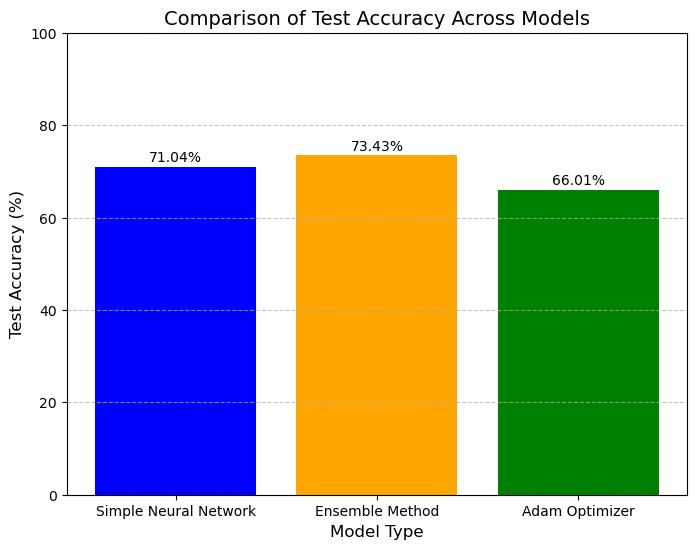

In [114]:
import matplotlib.pyplot as plt
import numpy as np


# Model names and corresponding test accuracies
model_names = ['Simple Neural Network', 'Ensemble Method', 'Adam Optimizer']
test_accuracies = [accuracy1,accuracy2,accuracy3]

# Plotting
together = plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, test_accuracies, color=['blue', 'orange', 'green'])

# Adding accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

# Plot aesthetics
plt.title('Comparison of Test Accuracy Across Models', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.ylim(0, 100)  # Adjust the range if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
together.savefig('/Users/hoon/Desktop/models_test_accuracy.jpg')

## 4-2 Training Efficiency

In [116]:
import time
import matplotlib.pyplot as plt

def train_and_record_time(model, X_train, y_train, epochs, batch_size):
    start_time = time.time()
    model.train(X_train, y_train, epochs=epochs, batch_size=batch_size)
    end_time = time.time()
    training_time = end_time - start_time
    return training_time


simple_nn = SimpleNeuralNetwork(input_size, [512, 256], output_size, learning_rate)
training_time_simple_nn = train_and_record_time(simple_nn1, X_train, y_train, epochs=30, batch_size=32)
boosted_nn = BoostedNeuralNetwork(SimpleNeuralNetwork2, n_models=3, input_size=X_train.shape[1], hidden_sizes=[512,256], output_size=y_train.shape[1], learning_rate=0.01)
training_time_boosted_nn = train_and_record_time(boosted_nn, X_train, y_train, epochs=30, batch_size=32)
nn_adam = NeuralNetworkWithAdam(X_train.shape[1], [512, 256], y_train.shape[1], 0.001)
training_time_nn_adam = train_and_record_time(nn_adam, X_train, y_train, epochs=30, batch_size=32)

Training model 1/3
Training model 2/3


/var/folders/mz/fktgp6vj62l5dw84vjcg4zj40000gn/T/ipykernel_39032/2044946506.py:67: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


Training model 3/3


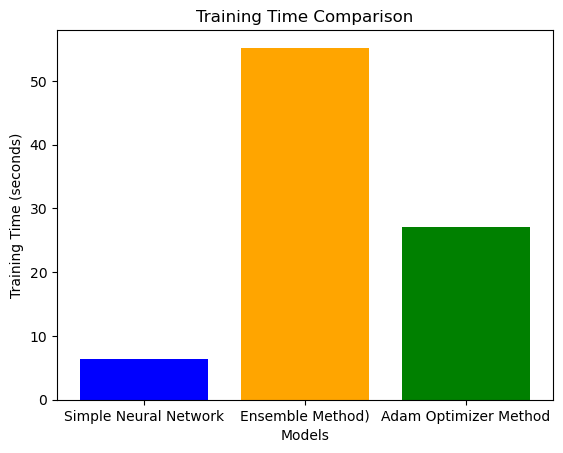

In [118]:
# Store the training time for comparison
training_times = {
    "Simple Neural Network": training_time_simple_nn,
    "Ensemble Method)": training_time_boosted_nn,
    "Adam Optimizer Method": training_time_nn_adam
}

# Visualize training time comparison
plt.bar(training_times.keys(), training_times.values(), color=['blue', 'orange', 'green'])
plt.xlabel("Models")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.show()